<div style="text-align: left;">
<table style="width:100%; background-color:transparent;">
  <tr style="background-color:transparent;">
    <td align="center"; style="background-color:transparent;"><a href = "https://joliot.cea.fr/drf/joliot/recherche/neurospin"><img src="https://baobablab.github.io/bhb/images/collaborators/cea.jpg" width="35%"></td>
    <td align="center"; style="background-color:transparent; width: 50%;"><a href = "https://dataia.eu/"><img src="https://github.com/ramp-kits/brain_anatomy_schizophrenia/raw/main/DATAIA-h.png" width="80%"></a></td>
  </tr>
</table> 
</div>

<center><h1>Predict schizophrenia using brain anatomy</h1></center>


<center><i>Edouard Duchesnay, Antoine Grigis, Benoît Dufumier (Université Paris-Saclay, CEA, NeuroSpin), François Caud, Alexandre Gramfort (Université Paris-Saclay, DATAIA) </i></center>

Predict schizophrenia from brain grey matter (GM). 

## Dataset

There are 410 samples in the training set and 103 samples in the test set.


### Input data

Voxel-based_morphometry [VBM](https://en.wikipedia.org/wiki/Voxel-based_morphometry)
using [cat12](http://www.neuro.uni-jena.de/cat/) software which provides:

- Regions Of Interest (`rois`) of Grey Matter (GM) scaled for the Total
  Intracranial Volume (TIV): `[train|test]_rois.csv` 284 features.

- VBM GM 3D maps or images (`vbm3d`) of [voxels](https://en.wikipedia.org/wiki/Voxel) in the
  [MNI](https://en.wikipedia.org/wiki/Talairach_coordinates) space:
  `[train|test]_vbm.npz` contains 3D images of shapes (121, 145, 121).
  This npz contains the 3D mask and the affine transformation to MNI
  referential. Masking the brain provide *flat* 331 695 input features (voxels)
  for each participant.


## Descriptive statistics

In [13]:

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


         age                                                    
       count       mean        std   min   25%   50%   75%   max
set                                                             
test   103.0  33.466019  12.809935  14.0  23.5  31.0  41.0  66.0
train  410.0  33.068293  12.562225  15.0  22.0  29.0  43.0  65.0
           age
set   sex     
test  0.0   65
      1.0   38
train 0.0  257
      1.0  153


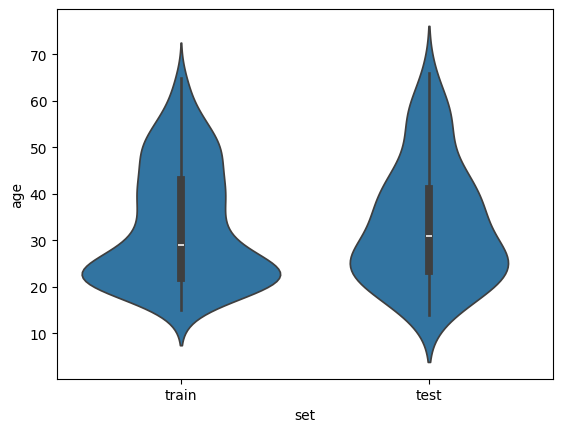

In [14]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pdb

participants_train = pd.read_csv(os.path.join("data", "train_participants.csv" ))
participants_train["set"] = 'train'
participants_test = pd.read_csv(os.path.join("data", "test_participants.csv" ))
participants_test["set"] = 'test'
participants = pd.concat([participants_train, participants_test])

sns.violinplot(x="set", y="age", data=participants)
print(participants[["age", "set"]].groupby("set").describe())
print(participants[["set", "sex", "age"]].groupby(["set", "sex"]).count())

## Unsupervized analysis: Explore main sources of variabilities

Load ROIs data, `train_rois.csv` provides:

- Global volumes of "tissues": CerrebroSpinal Fluid (`CSF_Vol`), Grey (`GM_Vol`) and White Matter (`WM_Vol`) volume of participants.
- ROIs are starting at column `l3thVen_GM_Vol`. Note that `rois_train.loc[:, 'l3thVen_GM_Vol':]` matches `problem.get_train_data()[:, :284]`.

In [15]:
rois_train = pd.read_csv(os.path.join("data", "train_rois.csv" )).loc[:, 'l3thVen_GM_Vol':]
rois_test = pd.read_csv(os.path.join("data", "test_rois.csv" )).loc[:, 'l3thVen_GM_Vol':]
rois = pd.concat([rois_train, rois_test])

In [16]:
# rois_train = pd.read_csv(os.path.join("data", "train_rois.csv" )).loc[:, 'l3thVen_GM_Vol':]
rois_train.head()

,l3thVen_GM_Vol,r3thVen_GM_Vol,l4thVen_GM_Vol,r4thVen_GM_Vol,lAcc_GM_Vol,rAcc_GM_Vol,lAmy_GM_Vol,rAmy_GM_Vol,lBst_GM_Vol,rBst_GM_Vol,...,lSupParLo_CSF_Vol,rSupParLo_CSF_Vol,lSupTemGy_CSF_Vol,rSupTemGy_CSF_Vol,lTemPo_CSF_Vol,rTemPo_CSF_Vol,lInfFroAngGy_CSF_Vol,rInfFroAngGy_CSF_Vol,lTemTraGy_CSF_Vol,rTemTraGy_CSF_Vol
0,0.063950,0.058779,0.062019,0.063885,0.459166,0.495607,0.983571,1.016309,0.472519,0.458482,...,7.488130,8.622047,2.465118,2.656249,6.584050,6.213031,1.787291,2.043806,0.406808,0.403986
1,0.047534,0.044989,0.053391,0.068330,0.450894,0.434376,1.011141,0.993529,0.226344,0.301962,...,9.022685,8.544778,2.439144,2.533854,6.849889,6.730247,1.945829,2.325559,0.312825,0.426095
2,0.118209,0.088380,0.069014,0.053907,0.532099,0.547899,1.013026,0.963916,0.473561,0.486732,...,4.219249,4.258448,1.394717,1.773845,3.537319,3.663182,1.007794,0.856915,0.162711,0.193604
3,0.102882,0.084044,0.044932,0.045765,0.456206,0.459221,0.875521,0.814790,0.502073,0.506276,...,3.678205,3.383453,1.346163,1.897148,3.623939,3.865042,1.237802,1.206910,0.218570,0.204934
4,0.067550,0.065347,0.047114,0.051132,0.474947,0.491112,0.977416,0.973828,0.440044,0.484388,...,7.231215,7.043181,2.161728,2.069372,3.730283,4.239948,1.418323,1.626568,0.278396,0.292313


### PCA on ROIs: explore global effect of age

                 sum_sq     df          F        PR(>F)
diagnosis   2606.207928    1.0  29.245287  9.808873e-08
Residual   45538.013350  511.0        NaN           NaN
                 sum_sq     df          F    PR(>F)
diagnosis    791.094363    1.0  10.876419  0.001042
Residual   37167.493121  511.0        NaN       NaN


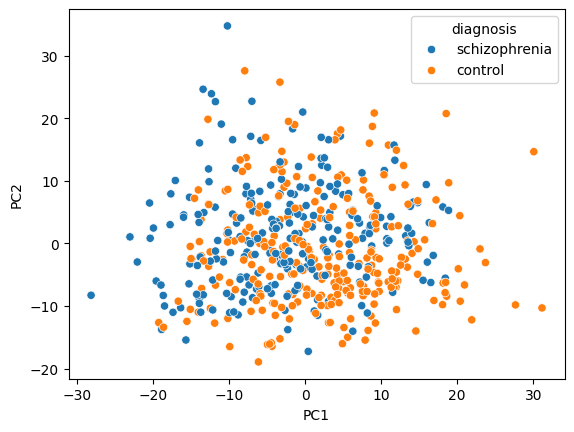

In [17]:
from sklearn.decomposition import PCA
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms

PCs = PCA(n_components=2).fit_transform(rois)
participants['PC1'], participants['PC2']  = PCs[:, 0], PCs[:, 1]

sns.scatterplot (x="PC1", y="PC2", hue="diagnosis",  data=participants)
oneway = smf.ols('PC1 ~ diagnosis', participants).fit()
print(sm.stats.anova_lm(oneway, typ=2))
oneway = smf.ols('PC2 ~ diagnosis', participants).fit()
print(sm.stats.anova_lm(oneway, typ=2))

Diagnosis is associated with two first components, we expect to be abble to predict the diagnosis

# Benchmarking Machine learning models



In [18]:
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.base import BaseEstimator
import sklearn.preprocessing as preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate
import sklearn.metrics as metrics
import problem

from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin

Load concatenated data: 284 features from ROIs and 331,695 features from VBM.

In [19]:
X_train, y_train = problem.get_train_data()
X_test, y_test = problem.get_test_data()

assert X_train.shape[1] == 284 + 331695

## Feature extractor of ROIs or voxels within the brain (VBM)

Selecting only rois or vbm images:

This can be achieved by a `ROIsFeatureExtractor` or `VBMFeatureExtractor` 

In [20]:
class ROIsFeatureExtractor(BaseEstimator, TransformerMixin):
    """Select only the 284 ROIs features:"""
    def fit(self, X, y):
        return self

    def transform(self, X):
        return X[:, :284]

class VBMFeatureExtractor(BaseEstimator, TransformerMixin):
    """Select only the 284 ROIs features:"""
    def fit(self, X, y):
        return self

    def transform(self, X):
        return X[:, 284:]
class SelectedFeaturesExtractor(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y):
        return self

    def transform(self, X):
        selected_roi = np.load('roi_selected.npy')
        selected_roi_indices = np.nonzero(selected_roi)[0]

        selected_vbm_indices = np.load('vbm_selected.npy')
        return X[:, np.concatenate((selected_roi_indices, selected_vbm_indices))]

class SelectedRoisFeaturesExtractor(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y):
        return self

    def transform(self, X):
        selected_roi = np.load('roi_selected.npy')
        selected_roi_indices = np.nonzero(selected_roi)[0]

        # selected_vbm_indices = np.load('vbm_selected.npy')
        return X[:, selected_roi_indices]


fe = ROIsFeatureExtractor()
print(fe.transform(X_train).shape)

fe = VBMFeatureExtractor()
print(fe.transform(X_train).shape)

(410, 284)
(410, 331695)


## Design of predictors and their evaluation using CV and test set

The framework is evaluated with a cross-validation approach. The metrics used are the ROC-AUC (auc) and the balanced Accuracy (bacc).


In [21]:
import numpy as np

from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline


class ROIsFeatureExtractor(BaseEstimator, TransformerMixin):
    """Select only the 284 ROIs features:"""
    def fit(self, X, y):
        return self

    def transform(self, X):
        return X[:, :284]
    

class ROIsFeatureStdExtractor(BaseEstimator, TransformerMixin):
    """Select only the 284 ROIs features:"""
    def fit(self, X, y):
        return self

    def transform(self, X):
        return X[:, :284] / (np.std(X[:, :284], axis=0) + 1e-10)


def get_estimator():
    """Build your estimator here."""
    estimator = make_pipeline(
        ROIsFeatureExtractor(),
        MLPClassifier(max_iter=10000, random_state=42, hidden_layer_sizes=(200, 150, 100, 50, 25, )))

    return estimator

In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import Matern, ConstantKernel, DotProduct
from sklearn.metrics import accuracy_score


In [23]:
import scipy


mat_gp = scipy.io.loadmat('gp.mat')
gp_model_params = mat_gp['gp']  # Assuming 'gp' is the key for your GP model in the .mat file


In [24]:
# mat_gp['gp']['cf'][0][0][0][0]# ['cf']# [0][0]['lengthScale'][0][0]

In [25]:
# gp_model_params[0, 0]
from sklearn.gaussian_process.kernels import Matern, ConstantKernel, Sum
# Create likelihood function (Probit)
lik = 'probit'



In [26]:
from skopt import BayesSearchCV
from skopt.space import Integer, Categorical, Real
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
# from sklearn.metrics import accuracy_score
import time
from scipy.stats import loguniform  
from skopt import dump

In [27]:
def run_experiment(X_train, y_train, estimator, search_spaces, pkl_name, feature_dim = 'all'):
    """
    Core function that runs the expeirment for performing cross validation + Bayesian optimization for 
    hyperameter tuning.
    Args:
      X_train, y_train: the training features and labels
      estimator: a make_pipeline object consisting of preprocessing and model definition
      search_space: a dictionary of the hyperparameters and their ranges of values to search over using
      Bayesian optimization
      pkl_name: a string which is the name of BayesSearchCV object to be stored for later analysis
      feature_dim: a string which indicates whether the high, low, or all features of the data were used. 
    Returns:
      Prints the results of the Bayesian search. Results include final CV metrics consisting of BACC and ROC-AUC
      along with optimal hyperparameters found. 
    """
    start_time = time.time()
    # Initialize Bayesian Optimization search
    bayes_search = BayesSearchCV(estimator, search_spaces=search_spaces, n_iter=32,
                                 scoring=['balanced_accuracy', 'roc_auc', 'f1'], refit='f1',
                                 n_jobs=-1, cv=5, random_state=42, verbose=0)


    # Fit the model
    bayes_search.fit(X_train, y_train)

    # Extract the results
    scores = bayes_search.cv_results_
    best_index = bayes_search.best_index_
    model_name = bayes_search.estimator[-1].__class__.__name__
    print(f"{model_name} ({feature_dim} dim) - Best parameters:", bayes_search.best_params_)
    print(f"{model_name} ({feature_dim} dim) - Best balanced accuracy score:",
          scores['mean_test_balanced_accuracy'][best_index])
    print(f"{model_name} ({feature_dim} dim) - Best ROC-AUC score:",
          scores['mean_test_roc_auc'][best_index])
    print(f"{model_name} ({feature_dim} dim) - Best F1 score:",
          scores['mean_test_f1'][best_index])
    duration = time.time() - start_time
    dump(bayes_search, pkl_name)
    print(f"Bayesian Search CV took {duration:.2f} seconds to complete.")

In [28]:
label_map = {"schizophrenia": 1, "control": 0}
        # db.set_trace()
y_train_encoded = np.array([label_map[label] for label in y_train])
# y_train_encoded
y_train_encoded.shape

(410,)

## Gaussian process classifier

In [17]:
# this is for best parameter in low dim feature(ROI) for LogisticRegression
feature_dim = 'low'
from sklearn.gaussian_process.kernels import Matern, ConstantKernel, WhiteKernel
from sklearn.linear_model import LogisticRegression
# kernel = ConstantKernel() * DotProduct() + Matern(length_scale=0.01, nu=2.5)
kernel = ConstantKernel(constant_value=1.0602594470835007e-06) \
        * DotProduct(sigma_0=0.5306524059595551) + Matern( length_scale=0.3037844144218505, nu=2.5)

# kernel = 1.0 * Matern(length_scale=0.01, nu=1.5) + ConstantKernel() + WhiteKernel(noise_level=1e-9)
estimator = make_pipeline(
    # LabelTransformer(),
    # ROIsFeatureExtractor(),
    # ROIsFeatureStdExtractor(),
    StandardScaler(),
    # LabelTransformer(),
    GaussianProcessClassifier(kernel=kernel, random_state=42)
)

# estimator = make_pipeline(
#     # LabelTransformer(),
#     # ROIsFeatureExtractor(),
#     ROIsFeatureStdExtractor(),
#     # StandardScaler(),
#     # LabelTransformer(),
#     LogisticRegression(C=0.03718979441078695, 
#                            penalty='l1', 
#                            solver='liblinear')
# )

In [197]:

estimator.fit(X_train, y_train_encoded)
    

In [148]:
# X_train[:, :284]/ (np.std(X_train[:, :284], axis=0) + 1e-10)

In [195]:
from sklearn.metrics import balanced_accuracy_score, roc_auc_score
label_map = {"schizophrenia": 1, "control": 0}
        # db.set_trace()
y_test_encoded = np.array([label_map[label] for label in y_test])
y_pred = estimator.predict(X_test)
y_pred_score = estimator.predict_proba(X_test)[:, 1]
y_pred = (y_pred_score >= 0.6).astype(int)
print("ROC-AUC:", roc_auc_score(y_test, y_pred_score))
print("Balanced ACC", balanced_accuracy_score(y_test_encoded, y_pred))

ROC-AUC: 0.8359848484848484
Balanced ACC 0.7357954545454546


In [ ]:
import numpy as np

from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline


class ROIsFeatureExtractor(BaseEstimator, TransformerMixin):
    """Select only the 284 ROIs features:"""
    def fit(self, X, y):
        return self

    def transform(self, X):
        return X[:, :284]
    

class ROIsFeatureStdExtractor(BaseEstimator, TransformerMixin):
    """Select only the 284 ROIs features:"""
    def fit(self, X, y):
        return self

    def transform(self, X):
        'normalizing by the std deviation as mentioned by the mentioned Kaggle competitor'
        return X[:, :284] / np.std(X[:, :284], axis=0)


def get_estimator():
    """Build your estimator here."""
    estimator = make_pipeline(
        ROIsFeatureExtractor(),
        MLPClassifier(max_iter=10000, random_state=42, hidden_layer_sizes=(200, 150, 100, 50, 25, )))

    return estimator

## Random Forest Classifier

In [34]:


feature_dim = 'low'

# Create the pipeline
estimator = make_pipeline(
    
    ROIsFeatureExtractor(),
    # VBMFeatureExtractor(),
    StandardScaler(),
    RandomForestClassifier(random_state=42, max_features=None, n_estimators=100)
)
# Define the search space for Bayesian Optimization
search_spaces = {
    # 'randomforestclassifier__n_estimators': Integer(100, 1000),
    'randomforestclassifier__max_depth': Integer(1, 10),
    'randomforestclassifier__min_samples_split': Integer(2, 10),
    # 'randomforestclassifier__min_samples_leaf': Integer(1, 50),
    # 'randomforestclassifier__max_features': Categorical(['sqrt', 'log2', None])
}



In [35]:
run_experiment(X_train, y_train_encoded, estimator=estimator, search_spaces=search_spaces, pkl_name='rf-low-dim-f1.pkl', feature_dim = 'low')

/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:463: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:463: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:463: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:463: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:463: UserWarning: The objective has been evaluated

RandomForestClassifier (low dim) - Best parameters: OrderedDict([('randomforestclassifier__max_depth', 8), ('randomforestclassifier__min_samples_split', 10)])
RandomForestClassifier (low dim) - Best balanced accuracy score: 0.7472171214276477
RandomForestClassifier (low dim) - Best ROC-AUC score: 0.8178333117806803
RandomForestClassifier (low dim) - Best F1 score: 0.7204933803866347
Bayesian Search CV took 146.36 seconds to complete.


In [40]:
run_experiment(X_train, y_train, estimator=estimator, search_spaces=search_spaces, pkl_name='rf-low-dim.pkl', feature_dim = 'low')

RandomForestClassifier (low dim) - Best parameters: OrderedDict([('randomforestclassifier__max_depth', 8), ('randomforestclassifier__min_samples_split', 2), ('randomforestclassifier__n_estimators', 675)])
RandomForestClassifier (low dim) - Best balanced accuracy score: 0.7517625759731023
RandomForestClassifier (low dim) - Best ROC-AUC score: 0.8299357730936678
Bayesian Search CV took 10865.55 seconds to complete.


In [37]:

# Create the pipeline
estimator = make_pipeline(
    
    # ROIsFeatureExtractor(),
    VBMFeatureExtractor(),
    StandardScaler(),
    RandomForestClassifier(random_state=42, max_features=None, n_estimators=100)
)
# Define the search space for Bayesian Optimization
search_spaces = {
    # 'randomforestclassifier__n_estimators': Integer(100, 1000),
    'randomforestclassifier__max_depth': Integer(1, 10),
    'randomforestclassifier__min_samples_split': Integer(2, 10),
    # 'randomforestclassifier__min_samples_leaf': Integer(1, 50),
    # 'randomforestclassifier__max_features': Categorical(['sqrt', 'log2', None])
}



In [47]:
# run_experiment(X_train, y_train, estimator=estimator, search_spaces=search_spaces, pkl_name='rf-high-dim.pkl', feature_dim = 'high')
sum(y_test == 'schizophrenia') / y_test.shape[0]

0.46601941747572817

In [83]:
# from skopt import BayesSearchCV
from skopt.space import Real, Categorical
# from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


# Define the kernel
kernel = ConstantKernel() * DotProduct() + Matern(length_scale=0.01, nu=2.5)

# Create the pipeline
estimator = make_pipeline(
    # LabelTransformer(), 
    SelectedFeaturesExtractor(),
    StandardScaler(),
    GaussianProcessClassifier(kernel=kernel, random_state=42)
)

# Define the search space for Bayesian Optimization
search_spaces = {
    'gaussianprocessclassifier__kernel__k2__length_scale': Real(1e-6, 1e1, prior='log-uniform'),
    'gaussianprocessclassifier__kernel__k1__k2__sigma_0': Real(1e-6, 1e1, prior='log-uniform'),  # ConstantKernel parameter
    'gaussianprocessclassifier__kernel__k1__k1__constant_value': Real(1e-6, 1e1, prior='log-uniform'),   # DotProduct parameter
    # 'gaussianprocessclassifier__kernel__k2__nu': Real(1e-6, 1e1, prior='log-uniform'),   # DotProduct parameter
    # 'gaussianprocessclassifier__kernel__k2__length_scale': Real(1e-7, 1e1, prior='log-uniform')   # DotProduct parameter
}


In [86]:
# run_experiment(X_train, y_train=y_train_encoded, estimator=estimator, search_spaces=search_spaces, pkl_name='gp-low-dim.pkl', feature_dim = 'low')
run_experiment(X_train, y_train=y_train_encoded, estimator=estimator, search_spaces=search_spaces, pkl_name='gp-selected-dim.pkl', feature_dim = 'selected')

/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/l

GaussianProcessClassifier (selected dim) - Best parameters: OrderedDict([('gaussianprocessclassifier__kernel__k1__k1__constant_value', 0.4861518228524981), ('gaussianprocessclassifier__kernel__k1__k2__sigma_0', 1.5962500716886472e-05), ('gaussianprocessclassifier__kernel__k2__length_scale', 0.015357818918361629)])
GaussianProcessClassifier (selected dim) - Best balanced accuracy score: 0.7345449516502149
GaussianProcessClassifier (selected dim) - Best ROC-AUC score: 0.807030547293705
Bayesian Search CV took 115.98 seconds to complete.


In [86]:
# Define the kernel
kernel = ConstantKernel() * DotProduct() + Matern(length_scale=0.01, nu=2.5)

# Create the pipeline
estimator = make_pipeline(
    # LabelTransformer(), 
    # ROIsFeatureExtractor(),
    StandardScaler(),
    GaussianProcessClassifier(kernel=kernel, random_state=42)
)

# Define the search space for Bayesian Optimization
search_spaces = {
    'gaussianprocessclassifier__kernel__k2__length_scale': Real(1e-6, 1e1, prior='log-uniform'),
    'gaussianprocessclassifier__kernel__k1__k2__sigma_0': Real(1e-6, 1e1, prior='log-uniform'),  # ConstantKernel parameter
    'gaussianprocessclassifier__kernel__k1__k1__constant_value': Real(1e-6, 1e1, prior='log-uniform'),   # DotProduct parameter
    # 'gaussianprocessclassifier__kernel__k2__nu': Real(1e-6, 1e1, prior='log-uniform'),   # DotProduct parameter
    # 'gaussianprocessclassifier__kernel__k2__length_scale': Real(1e-7, 1e1, prior='log-uniform')   # DotProduct parameter
}

In [87]:
run_experiment(X_train, y_train=y_train_encoded, estimator=estimator, search_spaces=search_spaces, pkl_name='gp-all-dim.pkl', feature_dim = 'all')

/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/l

GaussianProcessClassifier (all dim) - Best parameters: OrderedDict([('gaussianprocessclassifier__kernel__k1__k1__constant_value', 1.0602594470835007e-06), ('gaussianprocessclassifier__kernel__k1__k2__sigma_0', 0.5306524059595551), ('gaussianprocessclassifier__kernel__k2__length_scale', 0.15451804708791608)])
GaussianProcessClassifier (all dim) - Best balanced accuracy score: 0.7209352414615573
GaussianProcessClassifier (all dim) - Best ROC-AUC score: 0.7952241475925685
Bayesian Search CV took 6737.15 seconds to complete.


## Logistic Regression

In [43]:
from sklearn.model_selection import RandomizedSearchCV
from skopt.space import Real, Categorical
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate
from sklearn.metrics import balanced_accuracy_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_approximation import RBFSampler
rbf_feature = RBFSampler(gamma=1, random_state=42)

# this is for best parameter in low dim feature(ROI) for LogisticRegression
param_distribution = {
    'logisticregression__C': Real(1e-4, 1, prior='log-uniform'), 
    'logisticregression__penalty': Categorical(['l1', 'l2']),
    # 'logisticregression__solver': ['saga', 'liblinear']
    
    
}

estimator = make_pipeline(
    ROIsFeatureExtractor(),
    StandardScaler(),
    # RBFSampler(gamma=1/30, n_components=42),
    LogisticRegression(random_state=42, max_iter=10000, solver='liblinear')
)

# estimator = make_pipeline(
#         StandardScaler(),
#         LogisticRegression(C=0.03718979441078695, 
#                            penalty='l1', 
#                            solver='liblinear')
#     )

# estimator = make_pipeline(
#     # SelectedRoisFeaturesExtractor(),
#     StandardScaler(),
#     LogisticRegression(C=0.16324984449114358, 
#                            penalty='l2', 
#                            solver='saga', random_state=42, max_iter=10000)
# )
  

In [53]:
print(estimator)
estimator.fit(X_train, y_train)
y_pred_train = estimator.predict(X_train)
y_pred_test = estimator.predict(X_test)
score_pred_test = estimator.predict_proba(X_test)[:, 1]

bacc_test = balanced_accuracy_score(y_test, y_pred_test)
auc_test = roc_auc_score(y_test, score_pred_test)
print("# Test")
print('bACC=%.2f' % bacc_test,
      'ROC-AUC=%.2f' % auc_test)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=0.16324984449114358, max_iter=10000,
                                    random_state=42, solver='saga'))])


In [50]:
label_map = {"schizophrenia": 1, "control": 0}
        # db.set_trace()
y_test_encoded = np.array([label_map[label] for label in y_test])

for threshold in np.arange(0.4, 0.61, 0.01):
    y_pred_train = estimator.predict(X_train)
    y_pred_test = estimator.predict(X_test)
    score_pred_test = estimator.predict_proba(X_test)[:, 1]
    y_pred_test = (score_pred_test >= threshold).astype(int)
    bacc_test = balanced_accuracy_score(y_test_encoded, y_pred_test)
    auc_test = roc_auc_score(y_test, score_pred_test)
    print(threshold)
    print("# Test")
    print('bACC=', bacc_test,
        'ROC-AUC=', auc_test)

0.4
# Test
bACC= 0.768560606060606 ROC-AUC= 0.8106060606060606
0.41000000000000003
# Test
bACC= 0.768560606060606 ROC-AUC= 0.8106060606060606
0.42000000000000004
# Test
bACC= 0.768560606060606 ROC-AUC= 0.8106060606060606
0.43000000000000005
# Test
bACC= 0.768560606060606 ROC-AUC= 0.8106060606060606
0.44000000000000006
# Test
bACC= 0.7581439393939394 ROC-AUC= 0.8106060606060606
0.45000000000000007
# Test
bACC= 0.737310606060606 ROC-AUC= 0.8106060606060606
0.4600000000000001
# Test
bACC= 0.7464015151515151 ROC-AUC= 0.8106060606060606
0.4700000000000001
# Test
bACC= 0.7359848484848486 ROC-AUC= 0.8106060606060606
0.4800000000000001
# Test
bACC= 0.7359848484848486 ROC-AUC= 0.8106060606060606
0.4900000000000001
# Test
bACC= 0.7255681818181818 ROC-AUC= 0.8106060606060606
0.5000000000000001
# Test
bACC= 0.7255681818181818 ROC-AUC= 0.8106060606060606
0.5100000000000001
# Test
bACC= 0.7255681818181818 ROC-AUC= 0.8106060606060606
0.5200000000000001
# Test
bACC= 0.7255681818181818 ROC-AUC= 0.81060

In [42]:
# run_experiment(X_train, y_train, estimator=estimator, search_spaces=param_distribution, pkl_name='selected-roi-dim-rbf.pkl', feature_dim='selected-roi-rbf' )


LogisticRegression (selected-roi-rbf dim) - Best parameters: OrderedDict([('logisticregression__C', 79.8214770247646), ('logisticregression__penalty', 'l1')])
LogisticRegression (selected-roi-rbf dim) - Best balanced accuracy score: 0.7485688319898846
LogisticRegression (selected-roi-rbf dim) - Best ROC-AUC score: 0.7978436570541835
Bayesian Search CV took 86.39 seconds to complete.


In [44]:
estimator = make_pipeline(
    ROIsFeatureExtractor(),
    StandardScaler(),
    # RBFSampler(gamma=1/30, n_components=42),
    LogisticRegression(random_state=42, max_iter=10000, solver='liblinear')
)

In [45]:
run_experiment(X_train, y_train_encoded, estimator=estimator, search_spaces=param_distribution, pkl_name='log-reg-low-dim-f1.pkl', feature_dim='low' )


LogisticRegression (low dim) - Best parameters: OrderedDict([('logisticregression__C', 0.08339495371647725), ('logisticregression__penalty', 'l1')])
LogisticRegression (low dim) - Best balanced accuracy score: 0.7645636306162622
LogisticRegression (low dim) - Best ROC-AUC score: 0.8335212724686409
LogisticRegression (low dim) - Best F1 score: 0.7454151668804002
Bayesian Search CV took 71.22 seconds to complete.


In [41]:
# this is for best parameter in low dim feature(ROI) for LogisticRegression
param_distribution = {
    'logisticregression__C': Real(1e-3, 1, prior='log-uniform'), 
    'logisticregression__penalty': Categorical(['l1', 'l2']),
    # 'logisticregression__solver': ['saga', 'liblinear']
    
    
}

estimator = make_pipeline(
    # ROIsFeatureExtractor(),
    VBMFeatureExtractor(),
    StandardScaler(),
    LogisticRegression(random_state=42, max_iter=10000, solver='liblinear')
)
run_experiment(X_train, y_train_encoded, estimator=estimator, search_spaces=param_distribution, pkl_name='log-reg-high-dim-f1.pkl', feature_dim='high' )



LogisticRegression (high dim) - Best parameters: OrderedDict([('logisticregression__C', 0.25041499136197737), ('logisticregression__penalty', 'l1')])
LogisticRegression (high dim) - Best balanced accuracy score: 0.7673374570742992
LogisticRegression (high dim) - Best ROC-AUC score: 0.8407199304567726
LogisticRegression (high dim) - Best F1 score: 0.7491863198529864
Bayesian Search CV took 830.28 seconds to complete.


In [42]:
# this is for best parameter in low dim feature(ROI) for LogisticRegression
param_distribution = {
    'logisticregression__C': Real(1e-4, 1e0, prior='log-uniform'), 
    'logisticregression__penalty': Categorical(['l1', 'l2']),
    # 'logisticregression__solver': ['saga', 'liblinear']
    
    
}

estimator = make_pipeline(
    # ROIsFeatureExtractor(),
    # VBMFeatureExtractor(),
    StandardScaler(),
    LogisticRegression(random_state=42, max_iter=10000, solver='liblinear')
)
run_experiment(X_train, y_train_encoded, estimator=estimator, search_spaces=param_distribution, pkl_name='log-reg-all-dim-f1.pkl', feature_dim='all' )



LogisticRegression (all dim) - Best parameters: OrderedDict([('logisticregression__C', 0.03473954920711617), ('logisticregression__penalty', 'l1')])
LogisticRegression (all dim) - Best balanced accuracy score: 0.7900255039728725
LogisticRegression (all dim) - Best ROC-AUC score: 0.8627385519490783
LogisticRegression (all dim) - Best F1 score: 0.7735521561344345
Bayesian Search CV took 677.21 seconds to complete.


In [276]:
# this is for best parameter in low dim feature(ROI) for LogisticRegression
param_distribution = {
    'logisticregression__C': Real(1e-2, 1, prior='log-uniform'), 
    # 'logisticregression__l1_ratio': Real(0.01, 1e2, prior='log-uniform'),
    # 'logisticregression__penalty':  Categorical(['l1', 'l2']),
    'logisticregression__solver':  Categorical(['lbfgs', 'liblinear', 'sag', 'saga', 'newton-cg'])
    
    
}

estimator = make_pipeline(
    ROIsFeatureExtractor(),
    # VBMFeatureExtractor(),
    # SelectedRoisFeaturesExtractor(),
    StandardScaler(),
    LogisticRegression(random_state=42, max_iter=10000, penalty='l2')
)



In [277]:
run_experiment(X_train, y_train, estimator=estimator, search_spaces=param_distribution, pkl_name='log-reg-low-dim2.pkl', feature_dim='low2' )


/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:463: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:463: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:463: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:463: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:463: UserWarning: The objective has been evaluated

LogisticRegression (low2 dim) - Best parameters: OrderedDict([('logisticregression__C', 0.01), ('logisticregression__solver', 'liblinear')])
LogisticRegression (low2 dim) - Best balanced accuracy score: 0.7528896360475308
LogisticRegression (low2 dim) - Best ROC-AUC score: 0.8268624365992787
Bayesian Search CV took 84.75 seconds to complete.


In [41]:
run_experiment(X_train, y_train, estimator=estimator, search_spaces=param_distribution, pkl_name='log-reg-selected-dim-elasticnet.pkl', feature_dim='selected' )


LogisticRegression (selected dim) - Best parameters: OrderedDict([('logisticregression__C', 0.5608825209931844)])
LogisticRegression (selected dim) - Best balanced accuracy score: 0.7716077560814403
LogisticRegression (selected dim) - Best ROC-AUC score: 0.8492464474043422
Bayesian Search CV took 78.38 seconds to complete.


### Logistic regression with RBF kernel

In [21]:
from sklearn.kernel_approximation import RBFSampler


# Define the search space for Bayesian Optimization
search_spaces = {
    'logisticregression__C': Real(10, 1e4, prior='log-uniform'),
    'rbfsampler__n_components': Integer(512, 2048),
    # 'logisticregression__solver': Categorical(['saga', 'liblinear'])
}

# Create the pipeline
estimator = make_pipeline(
    SelectedRoisFeaturesExtractor(),
    StandardScaler(),
    RBFSampler(gamma=1),
    LogisticRegression(random_state=42, max_iter=10000, solver='liblinear', penalty='l1')
)


In [145]:
run_experiment(X_train, y_train, estimator=estimator, search_spaces=param_distribution, pkl_name='log-reg-low-dim-rbf.pkl', feature_dim='low-rbf' )


/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:463: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


LogisticRegression (low-rbf dim) - Best parameters: OrderedDict([('logisticregression__C', 9986.32465924921), ('logisticregression__penalty', 'l1')])
LogisticRegression (low-rbf dim) - Best balanced accuracy score: 0.5792530568846358
LogisticRegression (low-rbf dim) - Best ROC-AUC score: 0.5812956018219175
Bayesian Search CV took 80.83 seconds to complete.


## Naive Bayes classifier

In [23]:
# from skopt.space import Real, Categorical
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
# from skopt_edited import BayesSearchCV
from sklearn.naive_bayes import GaussianNB


# Define the search space for Bayesian Optimization
search_spaces = {
    'gaussiannb__var_smoothing': Real(1e-9, 1e1, prior='log-uniform')
}

# Create the pipeline
estimator = make_pipeline(
    SelectedRoisFeaturesExtractor(),
    StandardScaler(),
    GaussianNB()
)


In [24]:
run_experiment(X_train, y_train=y_train, estimator=estimator, search_spaces=search_spaces, pkl_name='gaussian-nb-selected-dim.pkl', feature_dim = 'selected')

/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:463: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:463: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:463: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:463: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:463: UserWarning: The objective has been evaluated

GaussianNB (selected dim) - Best parameters: OrderedDict([('gaussiannb__var_smoothing', 3.587400489798191)])
GaussianNB (selected dim) - Best balanced accuracy score: 0.719562121930543
GaussianNB (selected dim) - Best ROC-AUC score: 0.7882249953302585
Bayesian Search CV took 76.84 seconds to complete.


In [28]:
run_experiment(X_train, y_train=y_train, estimator=estimator, search_spaces=search_spaces, pkl_name='gaussian-nb-low-dim.pkl', feature_dim = 'low')

/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:463: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:463: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:463: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


GaussianNB (low dim) - Best parameters: OrderedDict([('gaussiannb__var_smoothing', 0.09897702960326314)])
GaussianNB (low dim) - Best balanced accuracy score: 0.6920302599249968
GaussianNB (low dim) - Best ROC-AUC score: 0.732413681624208
Bayesian Search CV took 80.25 seconds to complete.


## SVM

In [30]:
from sklearn.svm import SVC
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.utils.validation import check_is_fitted
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.base import TransformerMixin
class PrecomputedKernel(BaseEstimator, ClassifierMixin):
    def __init__(self, C=1):
        self.C = C
        self.svm = SVC(probability=True, random_state=42, kernel='precomputed', C=self.C)

    def fit(self, X, y):

        # Compute the linear kernel matrix for training data
        self.X_train_ = X  # Store the original training data
        kernel_matrix = rbf_kernel(X, X)
        self.svm.fit(kernel_matrix, y)
        self.classes_ = self.svm.classes_
        return self

    def predict(self, X):
        check_is_fitted(self)
        # Compute the kernel matrix for the test data
        kernel_matrix = rbf_kernel(X, self.X_train_)
        return self.svm.predict(kernel_matrix)

    def predict_proba(self, X):
        check_is_fitted(self)
        # Compute the kernel matrix for the test data
        kernel_matrix = rbf_kernel(X, self.X_train_)
        # This will only work if `probability=True` was set when initializing the SVM
        return self.svm.predict_proba(kernel_matrix)
    def decision_function(self, X):
        check_is_fitted(self)
        # Compute the kernel matrix for the test data
        kernel_matrix = rbf_kernel(X, self.X_train_)
        return self.svm.decision_function(kernel_matrix)



In [85]:
# Create the pipeline
estimator = make_pipeline(
    ROIsFeatureExtractor(),
    StandardScaler(),
    PrecomputedKernel(),
    # SVC(probability=True, random_state=42, kernel='precomputed')
)


# # Define the search space for Bayesian Optimization
search_spaces = {
    'precomputedkernel__C': Real(1e-6, 1e6, prior='log-uniform'),  # Regularization parameter
    # 'svc__gamma': Real(1e-4, 1e1, prior='log-uniform'),  # Kernel coefficient for 'rbf', 'poly', and 'sigmoid'
    # 'svc__kernel': Categorical(['rbf', 'linear', 'sigmoid', 'poly']),  # Kernel type
    # 'degree': Integer(1, 10),  # Degree of the polynomial kernel function (if 'poly' is chosen)
}

# # Define the search space for Bayesian Optimization
# search_spaces = {
#     'svc__C': Real(1e-6, 1e6, prior='log-uniform'),  # Regularization parameter
#     # 'svc__gamma': Real(1e-4, 1e1, prior='log-uniform'),  # Kernel coefficient for 'rbf', 'poly', and 'sigmoid'
#     # 'svc__kernel': Categorical(['rbf', 'linear', 'sigmoid', 'poly']),  # Kernel type
#     # 'degree': Integer(1, 10),  # Degree of the polynomial kernel function (if 'poly' is chosen)
# }
K_train = rbf_kernel(X_train[:, :284], X_train[:, :284])
scaler = StandardScaler()
K_train_scaled = scaler.fit_transform(K_train)
K_train_scaled.shape
# K_train = X_train.dot(X_train.T)
# K_train = X_train[:, selected_roi_indices].dot(X_train[:, selected_roi_indices].T)
# K_train_scaled = scaler.fit_transform(K_train)

(410, 410)

In [86]:
run_experiment(X_train, y_train_encoded, estimator=estimator, search_spaces=search_spaces, pkl_name='svm-low-dim-f1.pkl', feature_dim = 'low-dim')

/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:463: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:463: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:463: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:463: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


PrecomputedKernel (low-dim dim) - Best parameters: OrderedDict([('precomputedkernel__C', 0.08341564384216595)])
PrecomputedKernel (low-dim dim) - Best balanced accuracy score: 0.7314721180510654
PrecomputedKernel (low-dim dim) - Best ROC-AUC score: 0.8281752087015246
PrecomputedKernel (low-dim dim) - Best F1 score: 0.7008704500458286
Bayesian Search CV took 57.89 seconds to complete.


In [366]:
# # Create the pipeline
# estimator = make_pipeline(
#     # SelectedRoisFeaturesExtractor(),
#     # StandardScaler(),
#     SVC(probability=True, random_state=42, kernel='linear', C=0.21776603694820984,
#         gamma=3.9229485139656597)
# )


# print(estimator)

# K_train = rbf_kernel(X_train[:, selected_roi_indices], X_train[:, selected_roi_indices])
# K_train = X_train[:, selected_roi_indices].dot(X_train[:, selected_roi_indices].T)
# K_train_scaled = scaler.fit_transform(K_train)
# estimator.fit(K_train_scaled, y_train)
# K_test = X_test[:, selected_roi_indices].dot(X_train[:, selected_roi_indices].T)
# K_test_scaled = scaler.fit_transform(K_test)

# y_pred_train = estimator.predict(K_train_scaled)
# y_pred_test = estimator.predict(K_test_scaled)
# score_pred_test = estimator.predict_proba(K_test_scaled)[:, 1]

# bacc_test = balanced_accuracy_score(y_test, y_pred_test)
# auc_test = roc_auc_score(y_test, score_pred_test)
# print("# Test")
# print('bACC=%.2f' % bacc_test,
#       'ROC-AUC=%.2f' % auc_test)

Pipeline(steps=[('svc',
                 SVC(C=0.21776603694820984, gamma=3.9229485139656597,
                     kernel='linear', probability=True, random_state=42))])
# Test
bACC=0.69 ROC-AUC=0.75


In [87]:


estimator = make_pipeline(
    VBMFeatureExtractor(),
    StandardScaler(),
    PrecomputedKernel(),
    # SVC(probability=True, random_state=42, kernel='precomputed')
)


# # Define the search space for Bayesian Optimization
search_spaces = {
    'precomputedkernel__C': Real(1e-6, 1e6, prior='log-uniform'),  # Regularization parameter
    
}


In [88]:
run_experiment(X_train, y_train_encoded, estimator=estimator, search_spaces=search_spaces, pkl_name='svm-high-dim-precompute-f1.pkl', feature_dim = 'high')

/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:463: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:463: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:463: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:463: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:463: UserWarning: The objective has been evaluated

PrecomputedKernel (high dim) - Best parameters: OrderedDict([('precomputedkernel__C', 0.08341564384216595)])
PrecomputedKernel (high dim) - Best balanced accuracy score: 0.6608332974122448
PrecomputedKernel (high dim) - Best ROC-AUC score: 0.7670617986407461
PrecomputedKernel (high dim) - Best F1 score: 0.5902826989948515
Bayesian Search CV took 231.45 seconds to complete.


In [90]:
estimator = make_pipeline(
    StandardScaler(),
    PrecomputedKernel(),
    
)


# # Define the search space for Bayesian Optimization
search_spaces = {
    'precomputedkernel__C': Real(1e-6, 1e6, prior='log-uniform'),  # Regularization parameter
    # 'svc__gamma': Real(1e-4, 1e1, prior='log-uniform'),  # Kernel coefficient for 'rbf', 'poly', and 'sigmoid'
    # 'svc__kernel': Categorical(['rbf', 'linear', 'sigmoid', 'poly']),  # Kernel type
    # 'degree': Integer(1, 10),  # Degree of the polynomial kernel function (if 'poly' is chosen)
}



In [91]:
run_experiment(X_train, y_train_encoded, estimator=estimator, search_spaces=search_spaces, pkl_name='svm-all-dim-precompute-f1.pkl', feature_dim = 'all')

/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:463: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:463: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:463: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:463: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:463: UserWarning: The objective has been evaluated

PrecomputedKernel (all dim) - Best parameters: OrderedDict([('precomputedkernel__C', 0.08341564384216595)])
PrecomputedKernel (all dim) - Best balanced accuracy score: 0.6608332974122448
PrecomputedKernel (all dim) - Best ROC-AUC score: 0.7681393594551489
PrecomputedKernel (all dim) - Best F1 score: 0.5902826989948515
Bayesian Search CV took 229.74 seconds to complete.


## Neural network

In [18]:
from boruta import BorutaPy

rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)
feat_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42, max_iter=100)

feat_selector.fit(X_train[:, :284], y_train)

X_filtered = feat_selector.transform(X_train[:, :284])



Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	284
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	284
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	284
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	284
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	284
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	284
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	284
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	83
Rejected: 	201
Iteration: 	9 / 100
Confirmed: 	22
Tentative: 	61
Rejected: 	201
Iteration: 	10 / 100
Confirmed: 	22
Tentative: 	61
Rejected: 	201
Iteration: 	11 / 100
Confirmed: 	22
Tentative: 	61
Rejected: 	201
Iteration: 	12 / 100
Confirmed: 	23
Tentative: 	49
Rejected: 	212
Iteration: 	13 / 100
Confirmed: 	23
Tentative: 	49
Rejected: 	212
Iteration: 	14 / 100
Confirmed: 	23
Tentative: 	49
Rejected: 	212
Iteration: 	15 / 100
Confirmed: 	23
Tentative: 	49
Rejected: 	212
Iteration: 	16 / 100
Confirmed: 	2

In [22]:
# np.save('roi_selected.npy', feat_selector.support_)

## Feature selection

In [39]:
from sklearn.feature_selection import SelectKBest, f_classif




(410, 100)


In [38]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC


# # Create a pipeline with feature selection and classification model (SVM as an example)
# pipe = Pipeline([
#     ('select', SelectKBest(score_func=f_classif)),
#     ('model', SVC(kernel='rbf'))
# ])

# # Define the search space
# search_space = {
#     'select__k': Integer(100, 5000),  # Adjust the range based on your dataset and computational resources
#     # 'model__C': (1e-6, 100.0, 'log-uniform'),
#     # 'model__gamma': (1e-6, 100.0, 'log-uniform')
# }

# # Initialize Bayesian optimization with cross-validation
# opt = BayesSearchCV(
#     estimator=pipe,
#     search_spaces=search_space,
#     n_iter=32,  # Number of iterations
#     cv=5,  # 5-fold cross-validation
#     n_jobs=-1  # Use all available cores
# )

# # Perform the search
# opt.fit(X_train, y_train)

# # Best parameters and score
# print("Best parameters:", opt.best_params_)
# print("Best score:", opt.best_score_)

# # You can access the best number of features (k) like this:
# best_k = opt.best_params_['select__k']
# print("Best k value:", best_k)



/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:463: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:463: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:463: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:463: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:463: UserWarning: The objective has been evaluated

Best parameters: OrderedDict([('select__k', 100)])
Best score: 0.7658536585365854
Best k value: 100


In [ ]:
# Applying SelectKBest with the ANOVA F-value metric as a simple proxy to FCBF
# Choose k (e.g., 1000) based on your requirements or experimentation
selector = SelectKBest(f_classif, k=109000)
X_kbest_filtered = selector.fit_transform(X_train, y_train)



In [41]:
# X_new now contains the top 1000 selected features based on their ANOVA F-value
# print(X_vbm_filtered.shape)
selected_indices = selector.get_support(indices=True)

(410, 100)


In [43]:
# np.save('vbm_selected.npy', selected_indices)

In [47]:
selected_roi = np.load('roi_selected.npy')
indices = np.nonzero(selected_roi)[0]

array([ 26,  27,  28,  29,  46,  47,  54,  58,  61,  68,  78,  99, 108,
       135, 136, 137, 139, 186, 188, 189, 196, 197, 202, 203, 220, 221,
       230, 242, 250, 251, 258, 259, 282])

In [50]:
selected_vbm = np.load('vbm_selected.npy')
X_train[:, 284:][:, selected_vbm].shape

(410, 100)

In [53]:
X_train[:, np.concatenate((indices, selected_vbm))].shape

(410, 133)

In [60]:
import numpy as np

from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline


class ROIsFeatureExtractor(BaseEstimator, TransformerMixin):
    """Select only the 284 ROIs features:"""
    def fit(self, X, y):
        return self

    def transform(self, X):
        return X[:, :284]


def get_estimator():
    """Build your estimator here."""
    estimator = make_pipeline(
        ROIsFeatureExtractor(),
        MLPClassifier(max_iter=10000, random_state=42, hidden_layer_sizes=(200, 150, 100, 50, 25, )))

    return estimator

In [77]:
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from skopt.space import Space
import numpy as np

# Assuming ROIsFeatureExtractor is defined elsewhere and X_train, y_train are available

# Define the search space for Bayesian Optimization
search_spaces = {
    # 'mlpclassifier__hidden_layer_sizes': Categorical([generate_hidden_layer_sizes((5, 50), (10, 200)) for _ in range(100)]),
    # 'mlpclassifier__activation': Categorical(['relu', 'tanh', 'logistic']),
    'mlpclassifier__alpha': Real(1e1, 1e3, prior='log-uniform')
}

# Create the pipeline
estimator = make_pipeline(
    # ROIsFeatureExtractor(),
    SelectedRoisFeaturesExtractor(),
    StandardScaler(),
    # PCA(),
    MLPClassifier(random_state=42,  hidden_layer_sizes=(256, 128, 64, ))
)

In [ ]:
estimator.fit(X_train, y_train)
# Apply on test
y_pred_train = estimator.predict(X_train)
y_pred_test = estimator.predict(X_test)
score_pred_test = estimator.predict_proba(X_test)[:, 1]

bacc_test = balanced_accuracy_score(y_test, y_pred_test)
auc_test = roc_auc_score(y_test, score_pred_test)
print("# Test")
print('bACC=%.2f' % bacc_test,
      'ROC-AUC=%.2f' % auc_test)

In [78]:
# run_experiment(X_train, y_train, estimator=estimator, search_spaces=search_spaces, pkl_name='nn-select-dim.pkl', feature_dim = 'select')

/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier (all dim) - Best parameters: OrderedDict([('mlpclassifier__alpha', 17.83362958556913)])
MLPClassifier (all dim) - Best balanced accuracy score: 0.7333653749443223
MLPClassifier (all dim) - Best ROC-AUC score: 0.8057016825437879
Bayesian Search CV took 80.73 seconds to complete.


/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [70]:


feature_dim = 'low'
# Define the search space for Bayesian Optimization
search_spaces = {
    'logisticregression__C': Real(1e-4, 1e1, prior='log-uniform'),
    'logisticregression__penalty': Categorical(['l1', 'l2']),
    'logisticregression__solver': Categorical(['saga', 'liblinear'])
}

# Create the pipeline
estimator = make_pipeline(
    # ROIsFeatureExtractor(),
    SelectedFeaturesExtractor(),
    StandardScaler(),
    LogisticRegression(random_state=42, max_iter=10000)
)


In [71]:
run_experiment(X_train, y_train, estimator=estimator, search_spaces=search_spaces, pkl_name='logreg-selected-dim.pkl', feature_dim = 'selected')

LogisticRegression (selected dim) - Best parameters: OrderedDict([('logisticregression__C', 0.16485008617643668), ('logisticregression__penalty', 'l1'), ('logisticregression__solver', 'liblinear')])
LogisticRegression (selected dim) - Best balanced accuracy score: 0.761694828800092
LogisticRegression (selected dim) - Best ROC-AUC score: 0.8310188657557077
Bayesian Search CV took 92.23 seconds to complete.


# Stratified Cross Validation

In [93]:
from sklearn.model_selection import StratifiedGroupKFold, KFold
def run_stratified_experiment(X_train, y_train, estimator, search_spaces, pkl_name, feature_dim = 'all', stratify_group = participants_train, stratified=True):
    """
    Core function that runs the expeirment for performing common cross validation vs. stratified CV for hyperaparameter 
    tuning using Randomized Hyperparameter Search. 
    Args:
      X_train, y_train: the training features and labels
      estimator: a make_pipeline object consisting of preprocessing and model definition
      search_space: a dictionary of the hyperparameters and their ranges of values to search over using
      Bayesian optimization
      pkl_name: a string which is the name of Randomized search CV object to be stored for later analysis
      feature_dim: a string which indicates whether the high, low, or all features of the data were used. 
      stratify_group: a pd dataset containing the column to stratify
      stratified: a boolean flag indicating whether we run common cv vs. stratified CV. 
    Returns:
      Prints the results of the Bayesian search. Results include final CV metrics consisting of BACC, ROC-AUC
      and F1 score along with optimal hyperparameters found. 
    """
    
    start_time = time.time()
    # Initialize Random Optimization search

    if stratified:
      cv = StratifiedGroupKFold(n_splits=2) # same number as categories in 'sex'
      bayes_search = RandomizedSearchCV(estimator, param_distributions=search_spaces,
                                          scoring=['balanced_accuracy', 'roc_auc', 'f1'], refit='f1',
                                          n_jobs=-1, random_state=42, verbose=0, cv=cv)
      # Fit the model
      bayes_search.fit(X_train, y_train, groups=stratify_group['sex'])
    else:
      cv = KFold(n_splits=2)
      bayes_search = RandomizedSearchCV(estimator, param_distributions=search_spaces,
                                          scoring=['balanced_accuracy', 'roc_auc', 'f1'], refit='f1',
                                          n_jobs=-1, random_state=42, verbose=0, cv=cv)
      # Fit the model
      bayes_search.fit(X_train, y_train)

    # Extract the results
    scores = bayes_search.cv_results_
    best_index = bayes_search.best_index_
    model_name = bayes_search.estimator[-1].__class__.__name__
    print(f"{model_name} ({feature_dim} dim) - Best parameters:", bayes_search.best_params_)
    print(f"{model_name} ({feature_dim} dim) - Best balanced accuracy score:",
            scores['mean_test_balanced_accuracy'][best_index])
    print(f"{model_name} ({feature_dim} dim) - Best ROC-AUC score:",
            scores['mean_test_roc_auc'][best_index])
    print(f"{model_name} ({feature_dim} dim) - Best F1 score:",
            scores['mean_test_f1'][best_index])
    duration = time.time() - start_time
    dump(bayes_search, pkl_name)
    message = 'Stratified CV' if stratified else 'Common CV'
    print(f"Randomized, {message} Search took {duration:.2f} seconds to complete.")

## Logistic regression

In [310]:
# np.logspace(1e-3, 1, num=1000)

In [94]:
from skopt.space import Real, Categorical
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# this is for best parameter in low dim feature(ROI) for LogisticRegression
param_distribution = {
    'logisticregression__C': np.logspace(1e-3, 1, num=1000),  # Equivalent to Real(1, 1e4, prior='log-uniform')
    'logisticregression__penalty': ['l1', 'l2']  # Equivalent to Categorical(['l1', 'l2'])
    
}

estimator = make_pipeline(
    ROIsFeatureExtractor(),
    StandardScaler(),
    LogisticRegression(random_state=42, max_iter=10000, solver='liblinear')
)


In [96]:
run_stratified_experiment(X_train, y_train_encoded, estimator=estimator, search_spaces=param_distribution, pkl_name='stratified-logreg-low-dim.pkl', feature_dim='low', stratified=True)
run_stratified_experiment(X_train, y_train_encoded, estimator=estimator, search_spaces=param_distribution, pkl_name='commoncv-logreg-low-dim.pkl', feature_dim='low', stratified=False)


LogisticRegression (low dim) - Best parameters: {'logisticregression__penalty': 'l2', 'logisticregression__C': 1.1508003889444358}
LogisticRegression (low dim) - Best balanced accuracy score: 0.713895481999866
LogisticRegression (low dim) - Best ROC-AUC score: 0.7721819101901963
LogisticRegression (low dim) - Best F1 score: 0.6508045190003424
Randomized, Stratified CV Search took 6.24 seconds to complete.
LogisticRegression (low dim) - Best parameters: {'logisticregression__penalty': 'l2', 'logisticregression__C': 1.1508003889444358}
LogisticRegression (low dim) - Best balanced accuracy score: 0.6953555764411028
LogisticRegression (low dim) - Best ROC-AUC score: 0.7656222668107219
LogisticRegression (low dim) - Best F1 score: 0.6702898550724637
Randomized, Common CV Search took 6.36 seconds to complete.


In [97]:
param_distribution = {
    'logisticregression__C': np.logspace(1e-3, 1, num=1000),  # Equivalent to Real(1, 1e4, prior='log-uniform')
    'logisticregression__penalty': ['l1', 'l2']  # Equivalent to Categorical(['l1', 'l2'])
    
}

estimator = make_pipeline(
    VBMFeatureExtractor(),
    StandardScaler(),
    LogisticRegression(random_state=42, max_iter=10000, solver='liblinear')
)

In [98]:
run_stratified_experiment(X_train, y_train_encoded, estimator=estimator, search_spaces=param_distribution, pkl_name='stratified-logreg-high-dim.pkl', feature_dim='high', stratified=True)
run_stratified_experiment(X_train, y_train_encoded, estimator=estimator, search_spaces=param_distribution, pkl_name='commoncv-logreg-high-dim.pkl', feature_dim='high', stratified=False)


LogisticRegression (high dim) - Best parameters: {'logisticregression__penalty': 'l2', 'logisticregression__C': 1.1508003889444358}
LogisticRegression (high dim) - Best balanced accuracy score: 0.7007929543982782
LogisticRegression (high dim) - Best ROC-AUC score: 0.7778229771763685
LogisticRegression (high dim) - Best F1 score: 0.6342851810377007
Randomized, Stratified CV Search took 158.71 seconds to complete.
LogisticRegression (high dim) - Best parameters: {'logisticregression__penalty': 'l1', 'logisticregression__C': 6.606934480075961}
LogisticRegression (high dim) - Best balanced accuracy score: 0.7396727017323367
LogisticRegression (high dim) - Best ROC-AUC score: 0.8235973364496285
LogisticRegression (high dim) - Best F1 score: 0.7116540449573266
Randomized, Common CV Search took 159.98 seconds to complete.


In [99]:
param_distribution = {
    'logisticregression__C': np.logspace(1e-3, 1, num=1000),  # Equivalent to Real(1, 1e4, prior='log-uniform')
    'logisticregression__penalty': ['l1', 'l2']  # Equivalent to Categorical(['l1', 'l2'])
    
}

estimator = make_pipeline(
    StandardScaler(),
    LogisticRegression(random_state=42, max_iter=10000, solver='liblinear')
)

In [100]:
run_stratified_experiment(X_train, y_train_encoded, estimator=estimator, search_spaces=param_distribution, pkl_name='stratified-logreg-all-dim.pkl', feature_dim='all', stratified=True)
run_stratified_experiment(X_train, y_train_encoded, estimator=estimator, search_spaces=param_distribution, pkl_name='commoncv-logreg-all-dim.pkl', feature_dim='all', stratified=False)


LogisticRegression (all dim) - Best parameters: {'logisticregression__penalty': 'l2', 'logisticregression__C': 1.1508003889444358}
LogisticRegression (all dim) - Best balanced accuracy score: 0.6987268386957988
LogisticRegression (all dim) - Best ROC-AUC score: 0.7780052815030578
LogisticRegression (all dim) - Best F1 score: 0.6330019511288674
Randomized, Stratified CV Search took 99.43 seconds to complete.
LogisticRegression (all dim) - Best parameters: {'logisticregression__penalty': 'l1', 'logisticregression__C': 3.664375746478333}
LogisticRegression (all dim) - Best balanced accuracy score: 0.7566571992664947
LogisticRegression (all dim) - Best ROC-AUC score: 0.8336745456015405
LogisticRegression (all dim) - Best F1 score: 0.7359617682198327
Randomized, Common CV Search took 232.14 seconds to complete.


## RBF SVM

In [101]:
from sklearn.metrics.pairwise import rbf_kernel

estimator = make_pipeline(
    ROIsFeatureExtractor(),
    StandardScaler(),
    # SVC(kernel='rbf', probability=True)
    PrecomputedKernel()
)

# define grid search
grid = {
    'precomputedkernel__C' : np.arange(1e-1, 1e1)
}

# K_train = rbf_kernel(X_train[:, :284], X_train[:, :284])


In [102]:
run_stratified_experiment(X_train, y_train_encoded, estimator=estimator, search_spaces=grid, pkl_name='stratified-svm-low-dim.pkl', feature_dim='low', stratified=True)
run_stratified_experiment(X_train, y_train_encoded, estimator=estimator, search_spaces=grid, pkl_name='commoncv-svm-low-dim.pkl', feature_dim='low', stratified=False)


PrecomputedKernel (low dim) - Best parameters: {'precomputedkernel__C': 0.1}
PrecomputedKernel (low dim) - Best balanced accuracy score: 0.721193498154834
PrecomputedKernel (low dim) - Best ROC-AUC score: 0.7889351178021957
PrecomputedKernel (low dim) - Best F1 score: 0.651717032967033
Randomized, Stratified CV Search took 6.08 seconds to complete.
PrecomputedKernel (low dim) - Best parameters: {'precomputedkernel__C': 0.1}
PrecomputedKernel (low dim) - Best balanced accuracy score: 0.713703039673965
PrecomputedKernel (low dim) - Best ROC-AUC score: 0.8116167159100096
PrecomputedKernel (low dim) - Best F1 score: 0.676962797063581
Randomized, Common CV Search took 6.13 seconds to complete.


In [104]:
from sklearn.model_selection import (
    KFold,
    StratifiedGroupKFold,
    GridSearchCV,
)

estimator = make_pipeline(
    VBMFeatureExtractor(),
    StandardScaler(),
    # SVC(kernel='rbf', probability=True)
    PrecomputedKernel()
)

# define grid search
grid = {
    'precomputedkernel__C' : np.arange(1e-1, 1e1)
}

# K_train = rbf_kernel(X_train[:, :284], X_train[:, :284])


# K_train = rbf_kernel(X_train[:, 284:], X_train[:, 284:])


In [105]:
run_stratified_experiment(X_train, y_train_encoded, estimator=estimator, search_spaces=grid, pkl_name='stratified-svm-high-dim.pkl', feature_dim='high', stratified=True)
run_stratified_experiment(X_train, y_train_encoded, estimator=estimator, search_spaces=grid, pkl_name='common-svm-high-dim.pkl', feature_dim='high', stratified=False)


PrecomputedKernel (high dim) - Best parameters: {'precomputedkernel__C': 0.1}
PrecomputedKernel (high dim) - Best balanced accuracy score: 0.6188324534839333
PrecomputedKernel (high dim) - Best ROC-AUC score: 0.7569835886303562
PrecomputedKernel (high dim) - Best F1 score: 0.4059686767788877
Randomized, Stratified CV Search took 58.65 seconds to complete.
PrecomputedKernel (high dim) - Best parameters: {'precomputedkernel__C': 0.1}
PrecomputedKernel (high dim) - Best balanced accuracy score: 0.6299112425491882
PrecomputedKernel (high dim) - Best ROC-AUC score: 0.7455870247466172
PrecomputedKernel (high dim) - Best F1 score: 0.5558598028477546
Randomized, Common CV Search took 62.47 seconds to complete.


In [113]:
estimator = make_pipeline(
    # VBMFeatureExtractor(),
    StandardScaler(),
    # SVC(kernel='rbf', probability=True)
    PrecomputedKernel()
)

# define grid search
grid = {
    'precomputedkernel__C' : np.arange(1e-6, 1e6)
}

# K_train = rbf_kernel(X_train, X_train)


In [114]:
run_stratified_experiment(X_train, y_train_encoded, estimator=estimator, search_spaces=grid, pkl_name='stratified-svm-all-dim.pkl', feature_dim='all', stratified=True)
run_stratified_experiment(X_train, y_train_encoded, estimator=estimator, search_spaces=grid, pkl_name='commoncv-svm-all-dim.pkl', feature_dim='all', stratified=False)


PrecomputedKernel (all dim) - Best parameters: {'precomputedkernel__C': 121958.00000099998}
PrecomputedKernel (all dim) - Best balanced accuracy score: 0.6188324534839333
PrecomputedKernel (all dim) - Best ROC-AUC score: 0.7569795389658258
PrecomputedKernel (all dim) - Best F1 score: 0.4059686767788877
Randomized, Stratified CV Search took 68.31 seconds to complete.
PrecomputedKernel (all dim) - Best parameters: {'precomputedkernel__C': 121958.00000099998}
PrecomputedKernel (all dim) - Best balanced accuracy score: 0.6299112425491882
PrecomputedKernel (all dim) - Best ROC-AUC score: 0.7457305654164738
PrecomputedKernel (all dim) - Best F1 score: 0.5558598028477546
Randomized, Common CV Search took 57.81 seconds to complete.


## Random forest

In [110]:
feature_dim = 'low'

# Create the pipeline
estimator = make_pipeline(
    
    ROIsFeatureExtractor(),
    # VBMFeatureExtractor(),
    StandardScaler(),
    RandomForestClassifier(random_state=42, max_features=None, n_estimators=100)
)
# Define the search space for Bayesian Optimization
search_spaces = {
    # 'randomforestclassifier__n_estimators': Integer(100, 1000),
    'randomforestclassifier__max_depth': np.arange(1, 10 + 1),
    'randomforestclassifier__min_samples_split': np.arange(2, 10 + 1),
    # 'randomforestclassifier__min_samples_leaf': Integer(1, 50),
    # 'randomforestclassifier__max_features': Categorical(['sqrt', 'log2', None])
}



In [112]:
run_stratified_experiment(X_train, y_train_encoded, estimator=estimator, search_spaces=search_spaces, pkl_name='stratified-rf-low-dim.pkl', feature_dim='low', stratified=True)
run_stratified_experiment(X_train, y_train_encoded, estimator=estimator, search_spaces=search_spaces, pkl_name='commoncv-rf-low-dim.pkl', feature_dim='low', stratified=False)


RandomForestClassifier (low dim) - Best parameters: {'randomforestclassifier__min_samples_split': 9, 'randomforestclassifier__max_depth': 8}
RandomForestClassifier (low dim) - Best balanced accuracy score: 0.7475109836158441
RandomForestClassifier (low dim) - Best ROC-AUC score: 0.7990104748854153
RandomForestClassifier (low dim) - Best F1 score: 0.6834992887624467
Randomized, Stratified CV Search took 12.13 seconds to complete.
RandomForestClassifier (low dim) - Best parameters: {'randomforestclassifier__min_samples_split': 10, 'randomforestclassifier__max_depth': 5}
RandomForestClassifier (low dim) - Best balanced accuracy score: 0.7233865914786968
RandomForestClassifier (low dim) - Best ROC-AUC score: 0.797417177474478
RandomForestClassifier (low dim) - Best F1 score: 0.6957908728400533
Randomized, Common CV Search took 10.98 seconds to complete.


### RF doesn't scale

In [301]:
feature_dim = 'high'

# Create the pipeline
estimator = make_pipeline(
    
    # ROIsFeatureExtractor(),
    VBMFeatureExtractor(),
    StandardScaler(),
    RandomForestClassifier(random_state=42, max_features=None, n_estimators=100)
)
# Define the search space for Bayesian Optimization
search_spaces = {
    # 'randomforestclassifier__n_estimators': Integer(100, 1000),
    'randomforestclassifier__max_depth': np.arange(1, 10 + 1),
    'randomforestclassifier__min_samples_split': np.arange(2, 10 + 1),
    # 'randomforestclassifier__min_samples_leaf': Integer(1, 50),
    # 'randomforestclassifier__max_features': Categorical(['sqrt', 'log2', None])
}



In [ ]:
# run_stratified_experiment(X_train, y_train, estimator=estimator, search_spaces=search_spaces, pkl_name='stratified-rf-high-dim.pkl', feature_dim='high', stratified=True)
# run_stratified_experiment(X_train, y_train, estimator=estimator, search_spaces=search_spaces, pkl_name='commoncv-rf-high-dim.pkl', feature_dim='high', stratified=False)


# Plotting results

### Bayesian Search

In [10]:
from joblib import load
# Load the pickled file from the scikit-optimize experiment


In [31]:
# logistic regression models
logreg_all_dim = load('log-reg-all-dim-f1.pkl')
logreg_low_dim = load('log-reg-low-dim-f1.pkl')
logreg_high_dim = load('log-reg-high-dim-f1.pkl')
# rf
rf_low_dim = load('rf-low-dim-f1.pkl')

# svm models
svm_all_dim = load('svm-all-dim-precompute-f1.pkl')
svm_low_dim = load('svm-low-dim-f1.pkl')
svm_high_dim = load('svm-high-dim-precompute-f1.pkl')

In [32]:
def get_metrics(metric_name, metric_name_std, lst_mdls = [[logreg_low_dim, logreg_high_dim, logreg_all_dim], [svm_low_dim, svm_high_dim, svm_all_dim]], rf_low_dim=rf_low_dim):
    '''
    function that obtains the metrics per dataset dimension per model
    metrics that are returned include:
        maximum mean CV score (e.g. bacc or roc-auc)
        associated std. deviation per CV score 
        total fit time
        associated std. deviation of total fit time with error propagated
    '''

    val_scores_per_model = []
    val_scores_stds_per_model = []
    best_hparams_per_model = []
    fit_times_per_model = []
    fit_times_std_per_model = []
    for lst_mdl in lst_mdls:
        val_scores = []
        val_scores_std = []
        best_hparams = []
        fit_times = []
        fit_times_std = []
        for mdl in lst_mdl:
            val_scores.append(np.max(mdl.cv_results_[metric_name]))
            val_scores_std.append(mdl.cv_results_[metric_name_std]\
                                [np.argmax(mdl.cv_results_[metric_name])])
            best_hparams.append(', '.join([f"{key.split('__', 1)[1]}: {value:.4f}" if \
                                        isinstance(value, float) else f"{key.split('__', 1)[1]}: '{value}'" \
                                        for key, value in mdl.best_params_.items()]))
            fit_times.append(np.sum(mdl.cv_results_['mean_fit_time']))
            fit_times_std.append(np.sqrt(np.sum(mdl.cv_results_['std_fit_time']**2)))
        val_scores_per_model.append(val_scores)
        val_scores_stds_per_model.append(val_scores_std)
        best_hparams_per_model.append(best_hparams)
        fit_times_per_model.append(fit_times)
        fit_times_std_per_model.append(fit_times_std)

    # manually add dummy results for random forest since it failed
    val_scores_per_model.append([np.max(rf_low_dim.cv_results_[metric_name]), 0, 0])
    val_scores_stds_per_model.append([rf_low_dim.cv_results_[metric_name_std]\
                                [np.argmax(rf_low_dim.cv_results_[metric_name])], 0, 0])
    best_hparams_per_model.append([', '.join([f"{key.split('__', 1)[1]}: {value:.4f}" if \
                                        isinstance(value, float) else f"{key.split('__', 1)[1]}: '{value}'" \
                                        for key, value in rf_low_dim.best_params_.items()]), 'NA', 'NA'])
    fit_times_per_model.append([np.sum(rf_low_dim.cv_results_['mean_fit_time']), 0, 0])
    fit_times_std_per_model.append([np.sqrt(np.sum(rf_low_dim.cv_results_['std_fit_time']**2)), 0, 0])
    return val_scores_per_model, val_scores_stds_per_model, best_hparams_per_model, fit_times_per_model, fit_times_std_per_model



In [33]:
val_scores_per_model, val_scores_stds_per_model, best_hparams_per_model, fit_times_per_model, fit_times_std_per_model = get_metrics(metric_name='mean_test_balanced_accuracy', metric_name_std='std_test_balanced_accuracy')
val_scores_per_model_roc_auc, val_scores_stds_per_model_roc_auc, best_hparams_per_model, _, _ = get_metrics(metric_name='mean_test_f1', metric_name_std='std_test_f1')

In [34]:


def plot_metric_per_dim_per_mdl(scores, std_devs, ylabel, title, best_hparams=best_hparams_per_model):

    '''
    function that plots how the best cv metric (i.e. bacc and roc-auc) varies across models, across 
    dataset dimensions.

    Each bar is annotated with the score +/- std. deviation, along with the 
    best hparam found

    Args:
        scores:  max accuracy scores for each model on three datasets version low, high and all
        std_devs:  Standard deviations for the scores above
        best_hparams: hparam for each dataset for each model
    '''

    # Setting up the plot
    fig, ax = plt.subplots(figsize=(14, 8))
    # fig.subplots_adjust(top=11.85)  # Increase top spacing
    n_datasets = len(scores)
    n_models = len(scores[0])
    bar_width = 0.25
    index = np.arange(n_models)
    colors = ['r', 'g', 'b']

    # Plotting the bars
    for i in range(n_datasets):
        bars = plt.bar(index + i*bar_width, [score[i] for score in scores], bar_width, color=colors[i], yerr=[std[i] for std in std_devs], capsize=5)
        for bar, score, std_dev, hparam in zip(bars, [score[i] for score in scores], [std[i] for std in std_devs], [hparam[i] for hparam in best_hparams]):
            plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.05,
                    f'{score:.2f} ± {std_dev:.2f} \n hparam: {hparam}',
                    ha='center', va='bottom', fontsize=8, rotation=45)
    # Adding labels, title, and legend
    plt.xlabel('Model architectures', fontweight='bold')
    plt.ylabel(f'{ylabel}', fontweight='bold')
    plt.suptitle(f'{title}', fontweight='bold')
    plt.xticks(index + bar_width * (n_datasets-1) / 2, ['Logistic Regression', 'Precomuted RBF Kernel SVM', 'Random Forest'])
    plt.legend(['Low dim', 'High dim', 'All dim'])
    plt.grid(alpha=0.42)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    # ax.spines['bottom'].set_visible(False)
    # Displaying the plot
    plt.tight_layout()
    # plt.subplots_adjust(top=0.85)
    plt.show()



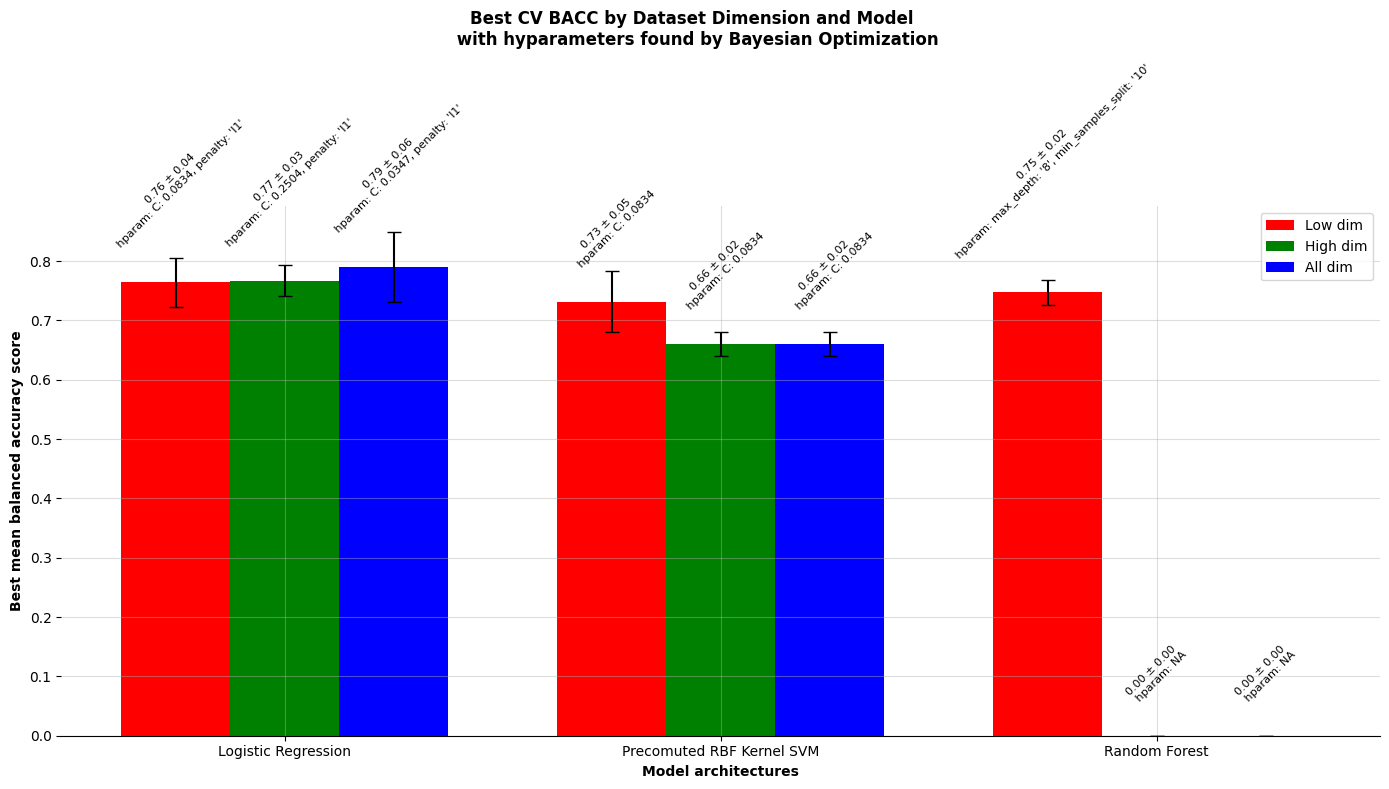

In [ ]:
plot_metric_per_dim_per_mdl(scores=val_scores_per_model, std_devs=val_scores_stds_per_model, ylabel='Best mean balanced accuracy score', title='Best CV BACC by Dataset Dimension and Model \n with hyparameters found by Bayesian Optimization', best_hparams=best_hparams_per_model)


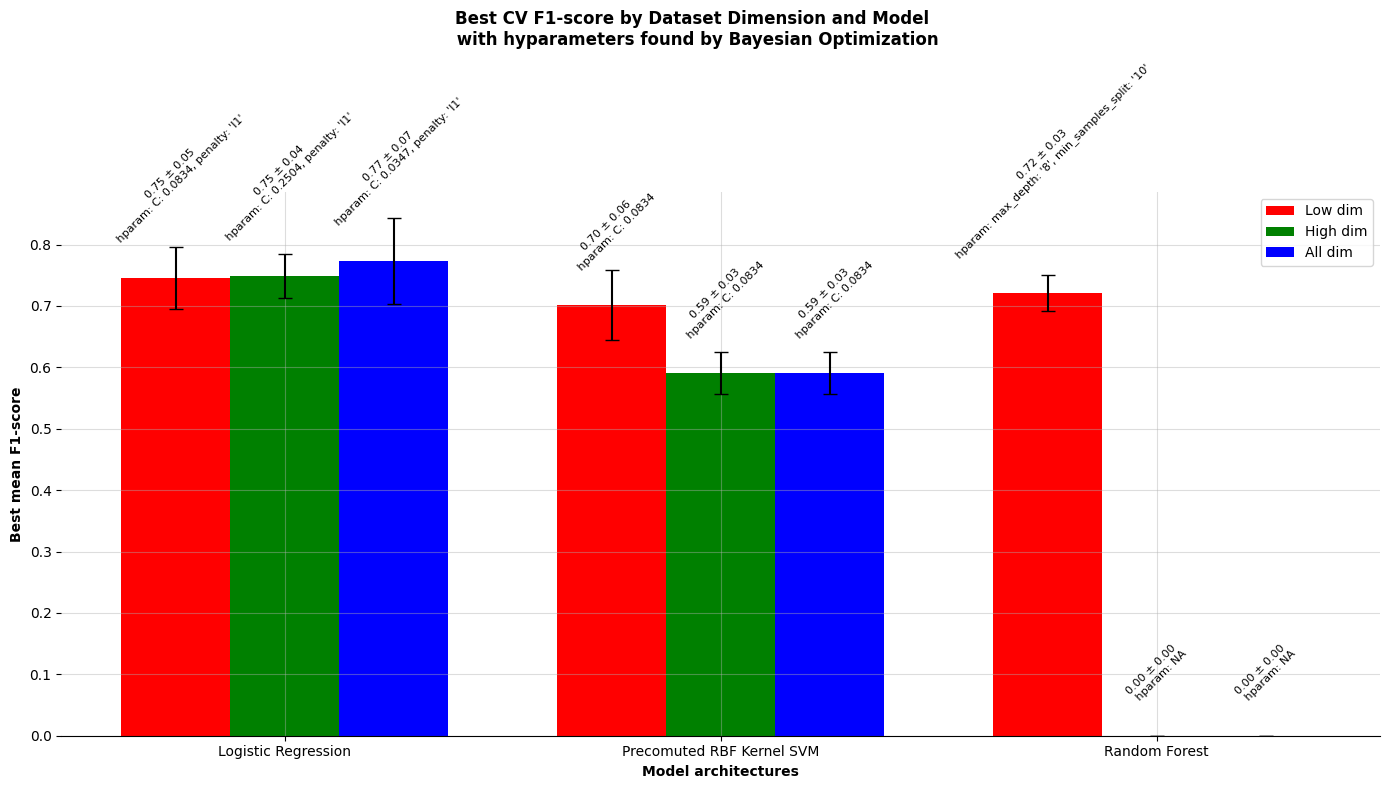

In [ ]:
plot_metric_per_dim_per_mdl(scores=val_scores_per_model_roc_auc, std_devs=val_scores_stds_per_model_roc_auc, \
                            ylabel='Best mean F1-score', title='Best CV F1-score by Dataset Dimension and Model \n with hyparameters found by Bayesian Optimization', best_hparams=best_hparams_per_model)


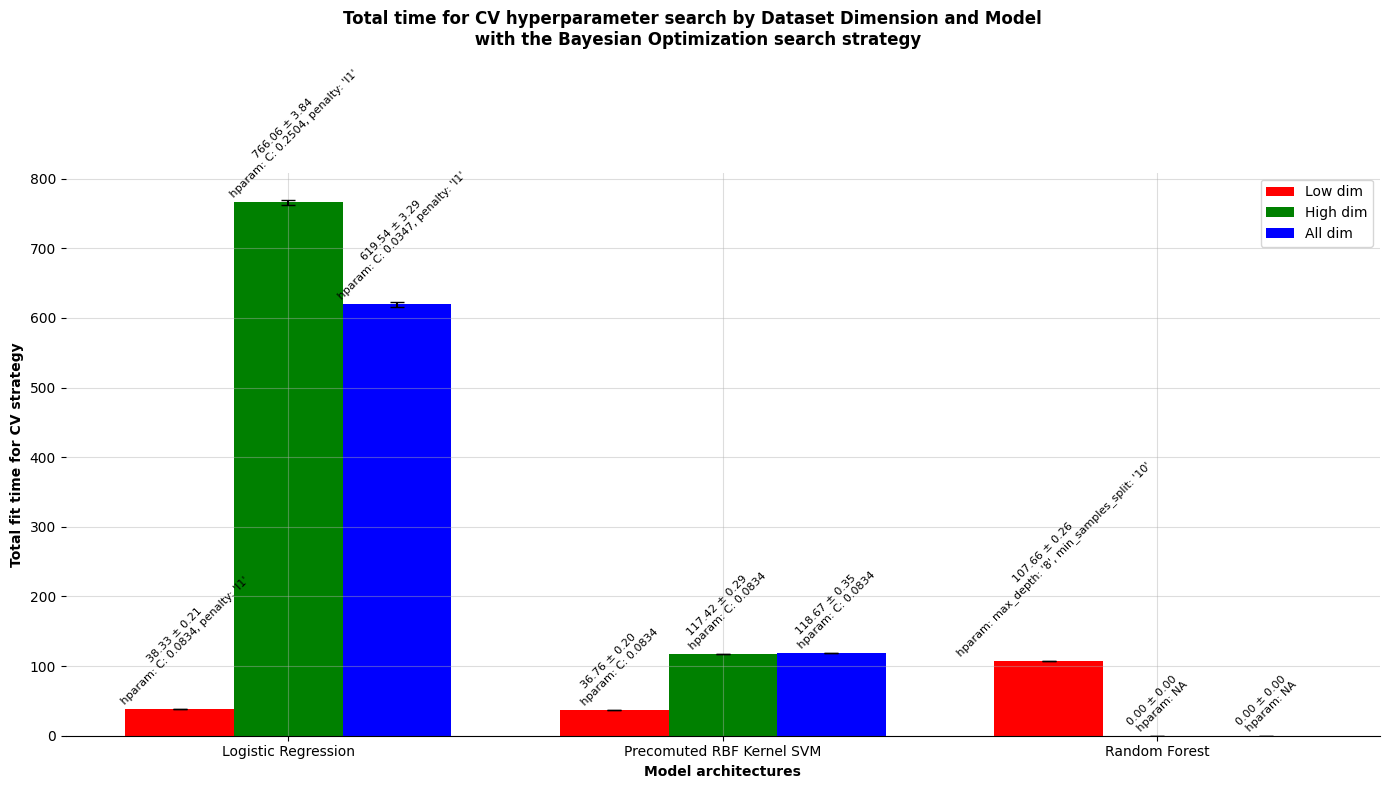

In [ ]:
plot_metric_per_dim_per_mdl(scores=fit_times_per_model, std_devs=fit_times_std_per_model, ylabel='Total fit time for CV strategy', title='Total time for CV hyperparameter search by Dataset Dimension and Model \n with the Bayesian Optimization search strategy', best_hparams=best_hparams_per_model)


## Common KFold

In [35]:
# logistic regression models
logreg_all_dim_common = load('commoncv-logreg-all-dim.pkl')
logreg_low_dim_common = load('commoncv-logreg-low-dim.pkl')
logreg_high_dim_common = load('commoncv-logreg-high-dim.pkl')
# rf
rf_low_dim_common = load('commoncv-rf-low-dim.pkl')

# svm models
svm_all_dim_common = load('commoncv-svm-all-dim.pkl')
svm_low_dim_common = load('commoncv-svm-low-dim.pkl')
svm_high_dim_common = load('common-svm-high-dim.pkl')

In [36]:
val_scores_per_model_common, val_scores_stds_per_model_common, best_hparams_per_model_common, fit_times_per_model_common, fit_times_std_per_model_common = get_metrics(metric_name='mean_test_balanced_accuracy', metric_name_std='std_test_balanced_accuracy', lst_mdls=[[logreg_low_dim_common, logreg_high_dim_common, logreg_all_dim_common],\
                                                                                                                                                                                                                                       [svm_low_dim_common, svm_high_dim_common, svm_all_dim_common]], rf_low_dim=rf_low_dim_common)
val_scores_per_model_roc_auc, val_scores_stds_per_model_roc_auc, best_hparams_per_model_common, _, _ = get_metrics(metric_name='mean_test_f1', metric_name_std='std_test_f1')

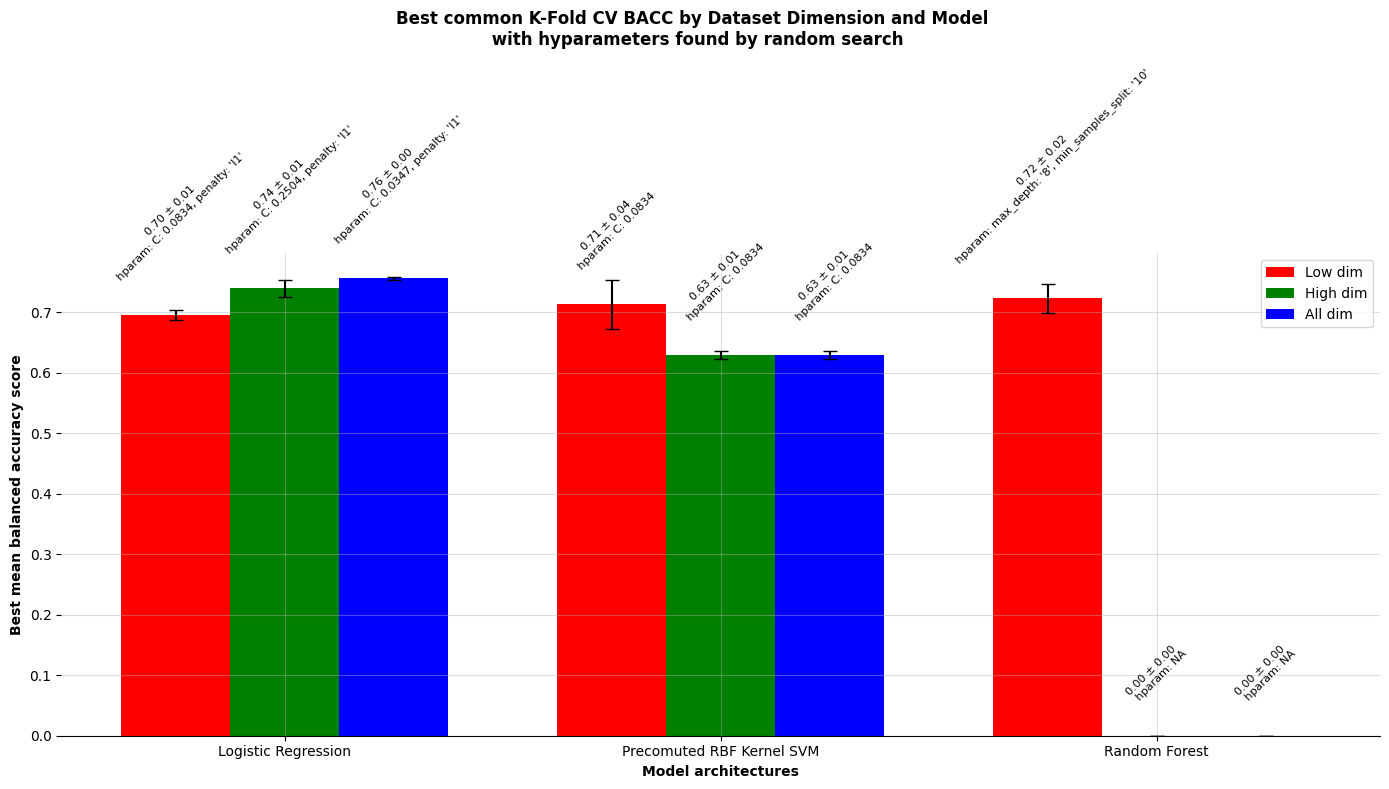

In [37]:
plot_metric_per_dim_per_mdl(scores=val_scores_per_model_common, std_devs=val_scores_stds_per_model_common, \
                            ylabel='Best mean balanced accuracy score', title='Best common K-Fold CV BACC by Dataset Dimension and Model \n with hyparameters found by random search', best_hparams=best_hparams_per_model_common)


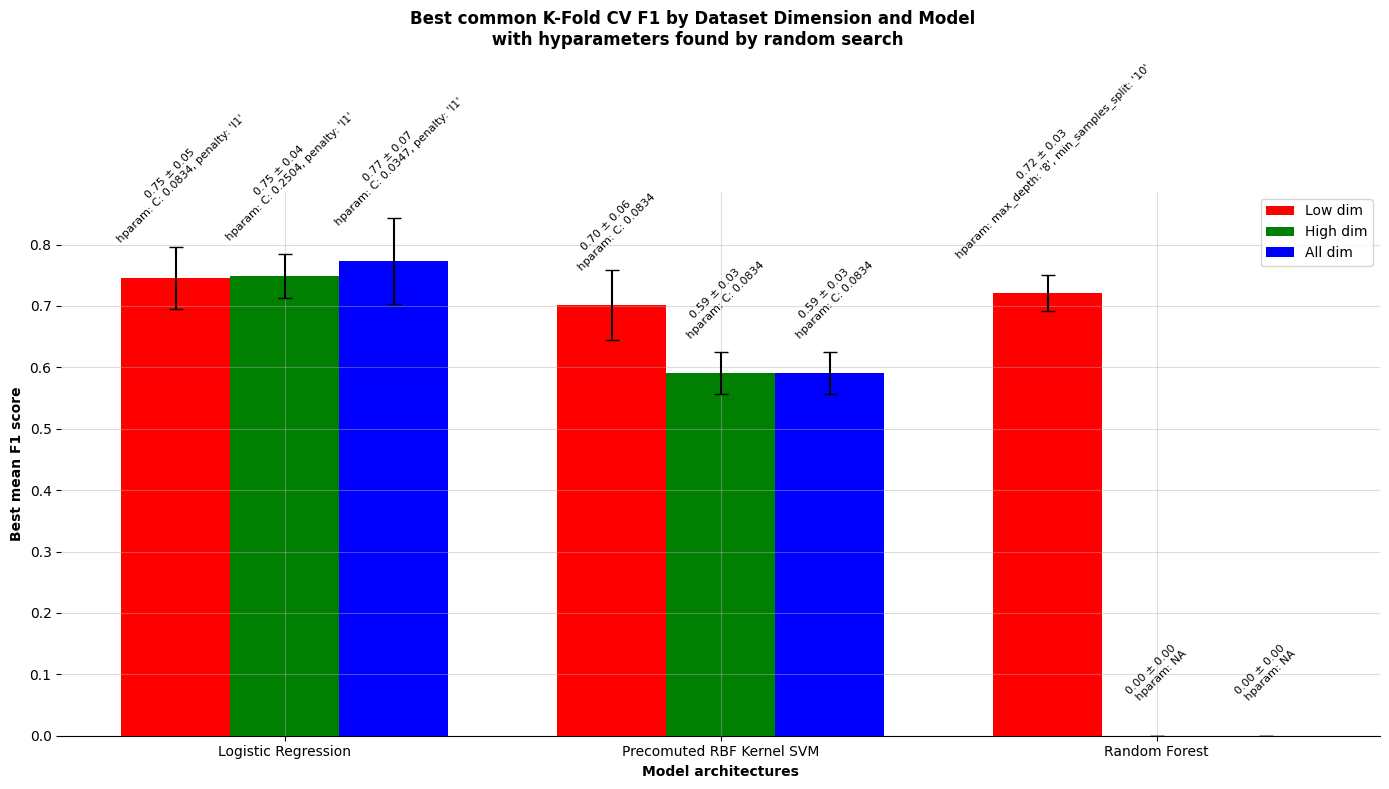

In [ ]:
plot_metric_per_dim_per_mdl(scores=val_scores_per_model_roc_auc, std_devs=val_scores_stds_per_model_roc_auc, \
                            ylabel='Best mean F1 score', title='Best common K-Fold CV F1 by Dataset Dimension and Model \n with hyparameters found by random search', best_hparams=best_hparams_per_model)


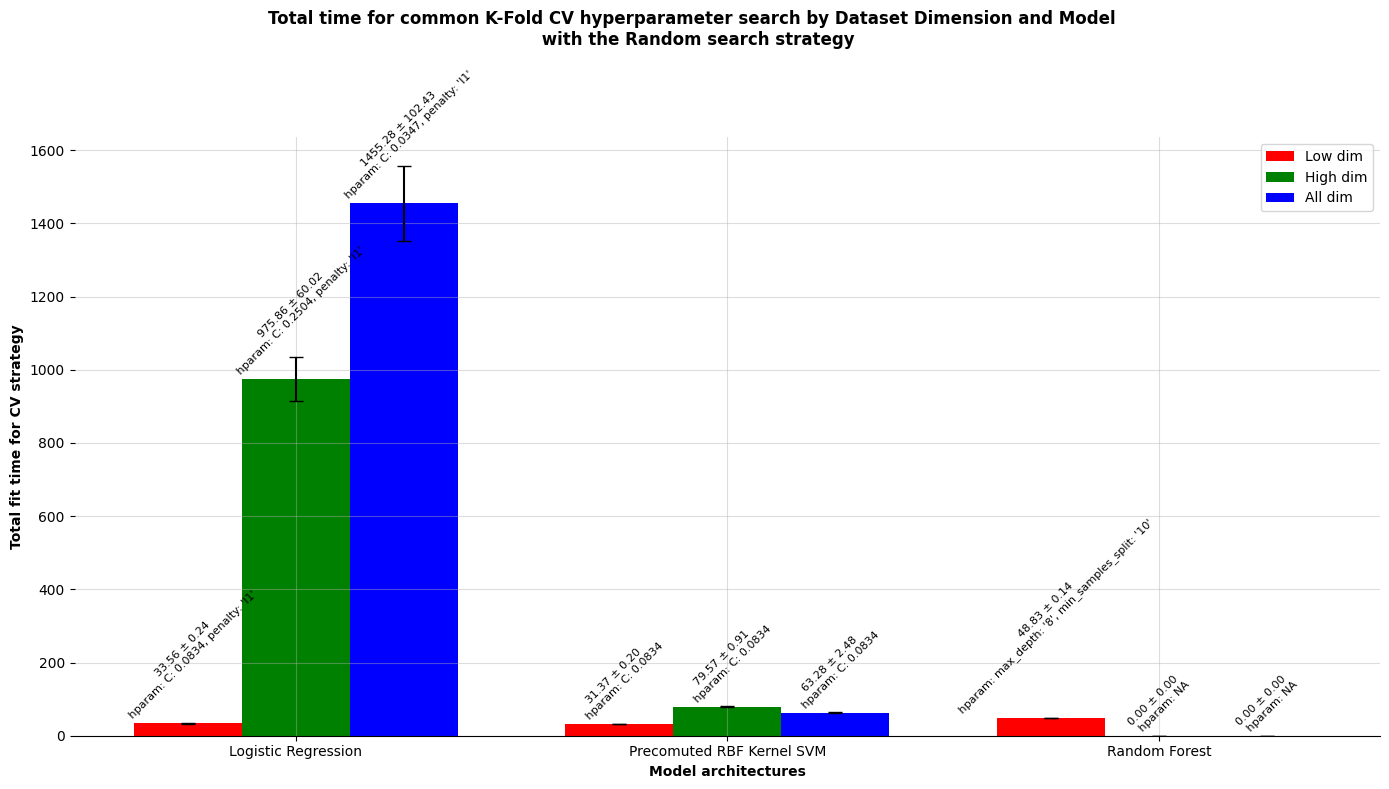

In [ ]:
plot_metric_per_dim_per_mdl(scores=fit_times_per_model, std_devs=fit_times_std_per_model, \
                            ylabel='Total fit time for CV strategy', title='Total time for common K-Fold CV hyperparameter search by Dataset Dimension and Model \n with the Random search strategy', best_hparams=best_hparams_per_model)


## Group-stratified K-Fold

In [ ]:
# logistic regression models
logreg_all_dim_group = load('stratified-logreg-all-dim.pkl')
logreg_low_dim_group = load('stratified-logreg-low-dim.pkl')
logreg_high_dim_group = load('stratified-logreg-high-dim.pkl')
# rf
rf_low_dim_group = load('stratified-rf-low-dim.pkl')

# svm models
svm_all_dim_group = load('stratified-svm-all-dim.pkl')
svm_low_dim_group = load('stratified-svm-low-dim.pkl')
svm_high_dim_group = load('stratified-svm-high-dim.pkl')

In [ ]:
val_scores_per_model, val_scores_stds_per_model, best_hparams_per_model_group, fit_times_per_model, fit_times_std_per_model = get_metrics(metric_name='mean_test_balanced_accuracy', metric_name_std='std_test_balanced_accuracy', lst_mdls=[[logreg_low_dim_group, logreg_high_dim_group, logreg_all_dim_group],\
                                                                                                                                                                                                                                       [svm_low_dim_group, svm_high_dim_group, svm_all_dim_group]], rf_low_dim=rf_low_dim_group)
val_scores_per_model_roc_auc, val_scores_stds_per_model_roc_auc, best_hparams_per_model_group, _, _ = get_metrics(metric_name='mean_test_f1', metric_name_std='std_test_f1')

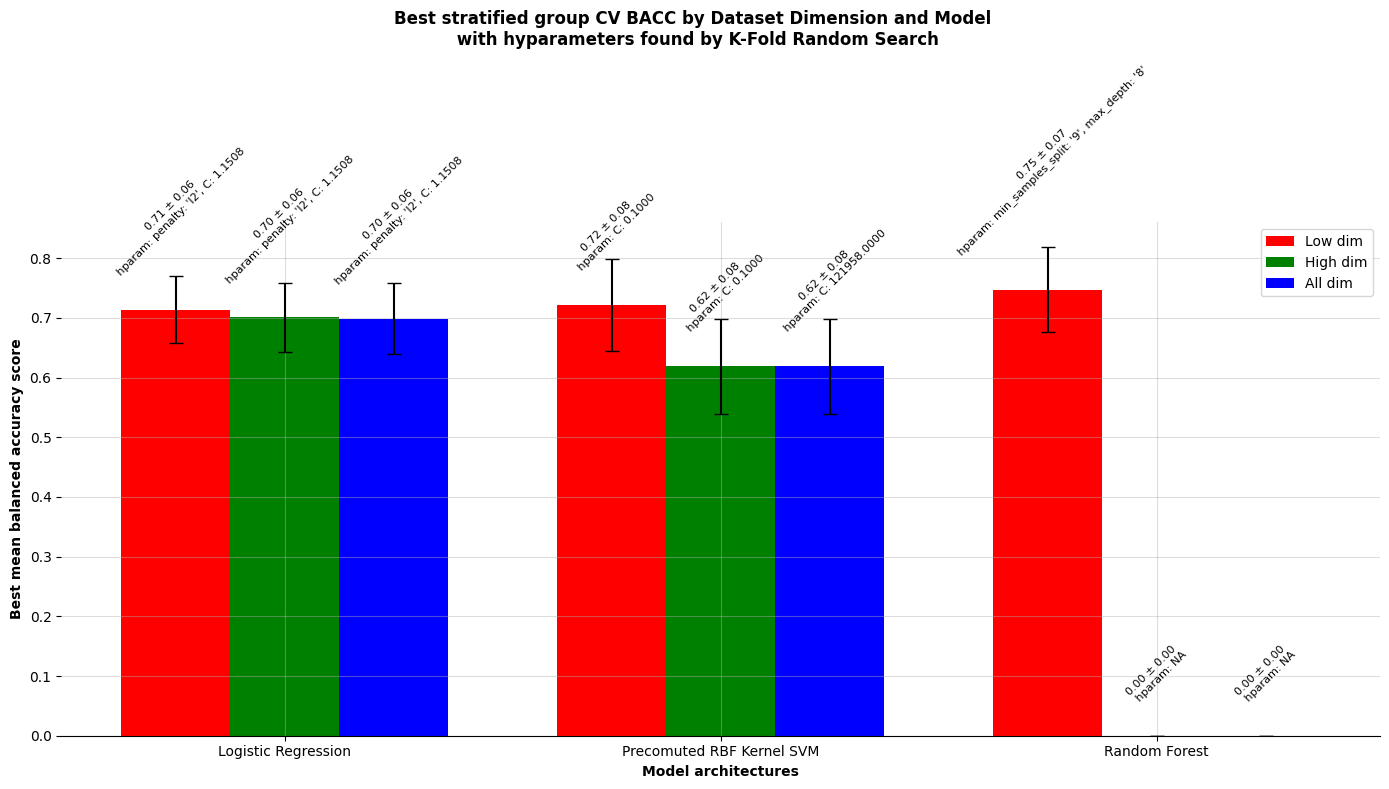

In [ ]:
plot_metric_per_dim_per_mdl(scores=val_scores_per_model, std_devs=val_scores_stds_per_model, \
                            ylabel='Best mean balanced accuracy score', title='Best stratified group CV BACC by Dataset Dimension and Model \n with hyparameters found by K-Fold Random Search', best_hparams=best_hparams_per_model_group)


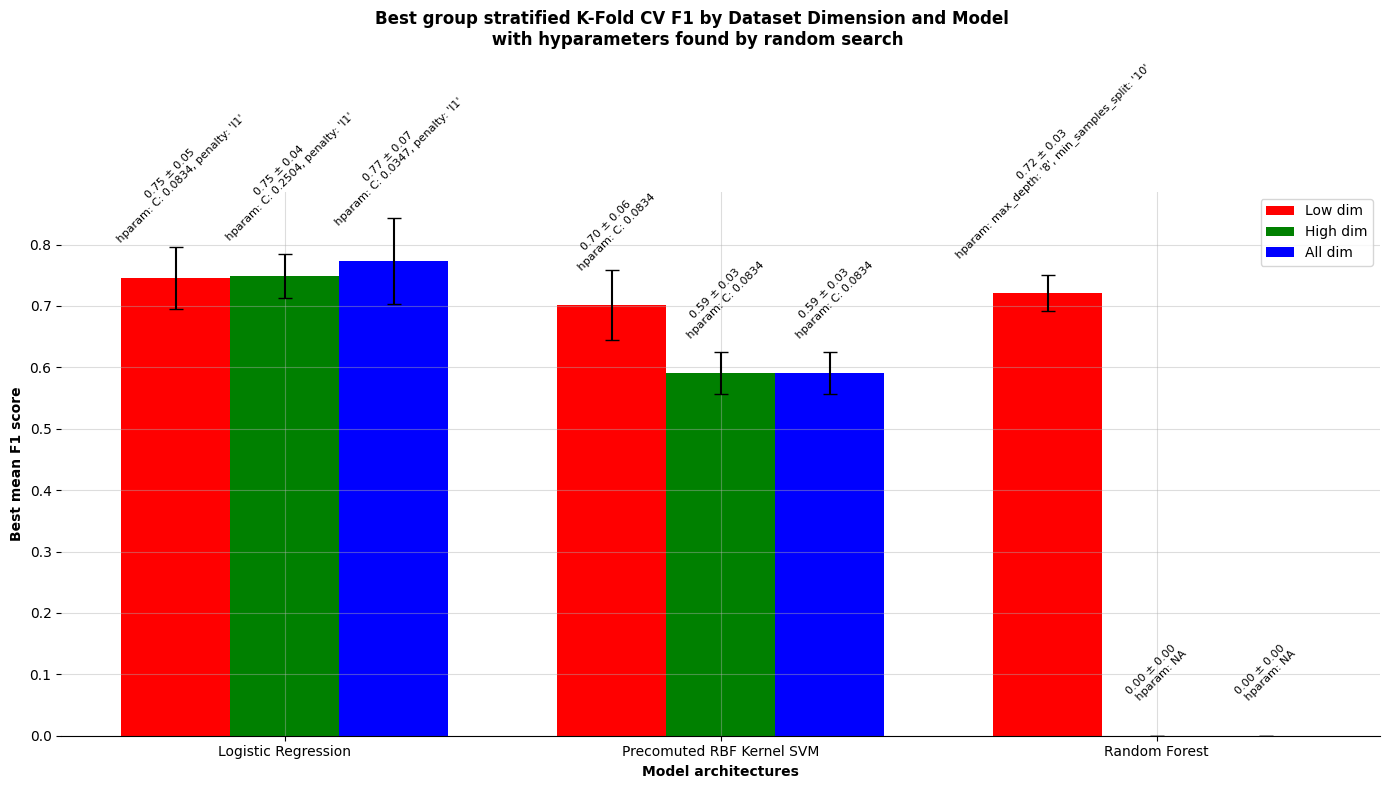

In [ ]:
plot_metric_per_dim_per_mdl(scores=val_scores_per_model_roc_auc, std_devs=val_scores_stds_per_model_roc_auc, \
                            ylabel='Best mean F1 score', title='Best group stratified K-Fold CV F1 by Dataset Dimension and Model \n with hyparameters found by random search', best_hparams=best_hparams_per_model)


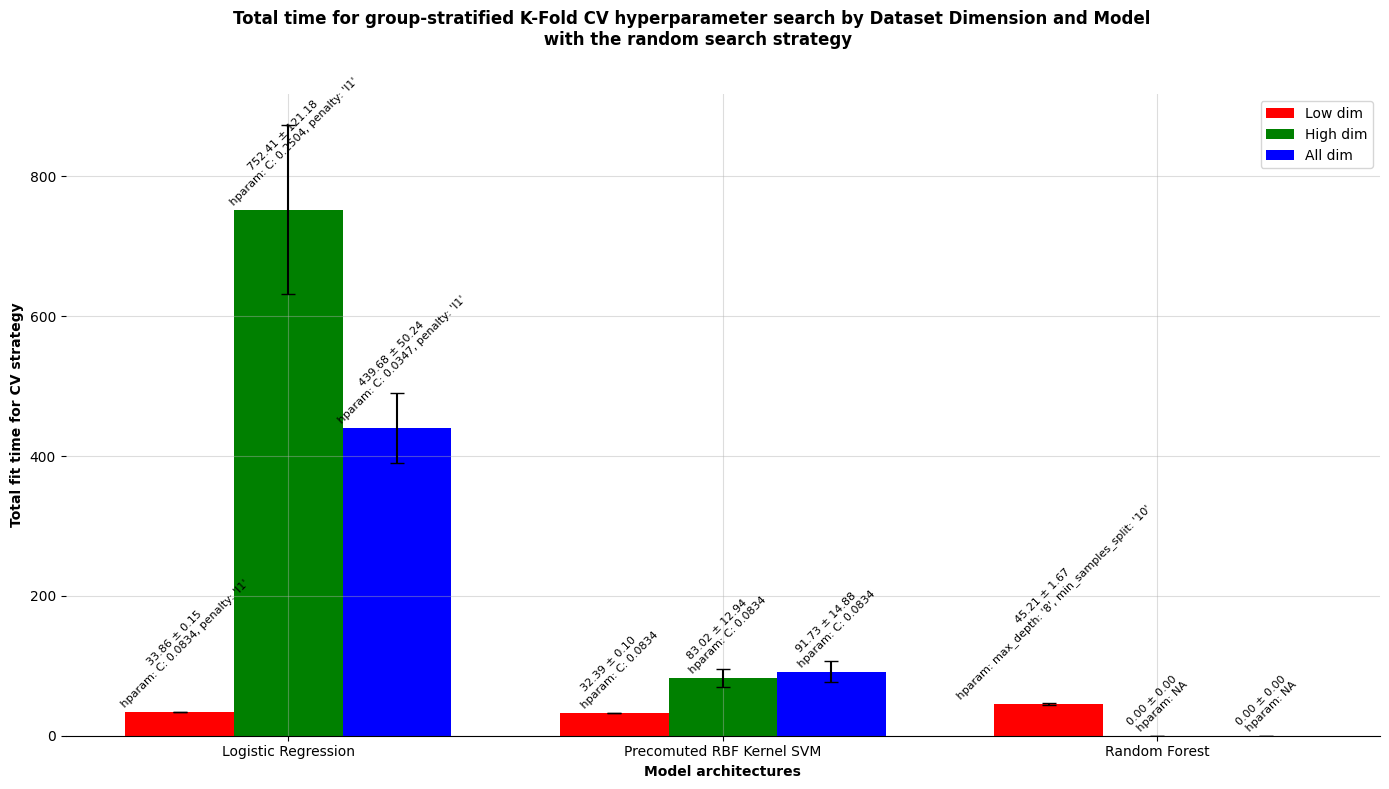

In [ ]:
plot_metric_per_dim_per_mdl(scores=fit_times_per_model, std_devs=fit_times_std_per_model, ylabel='Total fit time for CV strategy', title='Total time for group-stratified K-Fold CV hyperparameter search by Dataset Dimension and Model \n with the random search strategy', best_hparams=best_hparams_per_model)


## Scores across hyperparameters searched by search strategy

In [ ]:


def plot_val_scores_vs_hparam(mean_test_scores, std_test_scores, mean_test_scores2, std_test_scores2, hparam_paradigm, params, model_name, ymetric_label1='Mean Balanced Accuracy', ymetric_label2='ROC-AUC'):
    '''
    plot to visualize which hparams does the chosen optimization strategy samples and the subsequent
    bacc and roc-auc scores they yield
    
    '''
    simplified_params = []
    for param in params:
        simplified_param = ', '.join([f"{key.split('__', 1)[1]}: {value:.4f}" if isinstance(value, float) else f"{key.split('__', 1)[1]}: '{value}'" for key, value in param.items()])
        simplified_params.append(simplified_param)

    plt.figure(figsize=(12, 10))

    plt.errorbar(range(len(params)), mean_test_scores, yerr=std_test_scores, fmt='o', color='b', ecolor='r', capsize=5)
    plt.errorbar(range(len(params)), mean_test_scores2, yerr=std_test_scores2, fmt='x', color='g', ecolor='r', capsize=5)

    # Add annotations for each point
    space = 0.02
    for i, txt in enumerate(mean_test_scores):
        plt.text(i, mean_test_scores[i] + space, f'{mean_test_scores[i]:.3f} +/- {std_test_scores[i]:.3f}', fontsize=6)
        plt.text(i, mean_test_scores2[i] + space, f'{mean_test_scores2[i]:.3f} +/- {std_test_scores2[i]:.3f}', fontsize=6)

        space *= -1
    # Customize the plot
    plt.plot(range(len(simplified_params)), mean_test_scores, color='k', linestyle='-', marker='o', label=f'{ymetric_label1}')
    plt.plot(range(len(simplified_params)), mean_test_scores2, color='g', linestyle='-', marker='x', label=f'{ymetric_label2}')

    plt.xticks(range(len(simplified_params)), simplified_params, rotation='vertical')
    plt.xlabel('Hyperparameter Combination')
    plt.ylabel('Average scores')
    plt.title(f'Mean validation scores vs. Hyperparameter Combination searched with {hparam_paradigm} \n for {model_name}')
    plt.grid(True)
    plt.tight_layout()
    plt.legend()
    # Show the plot
    plt.show()


### Logistic regression metrics

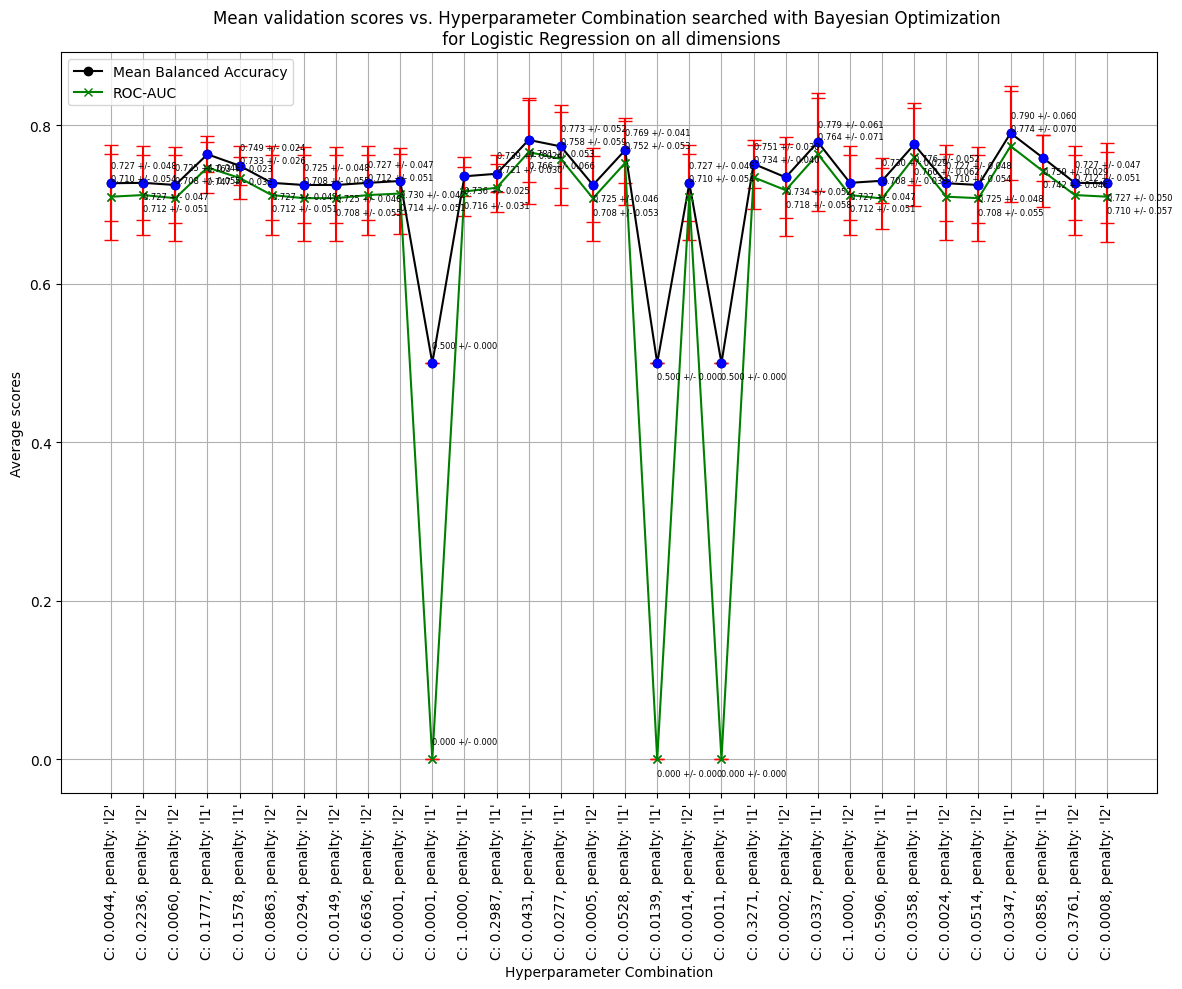

In [ ]:
plot_val_scores_vs_hparam(mean_test_scores=logreg_all_dim.cv_results_['mean_test_balanced_accuracy'], std_test_scores=logreg_all_dim.cv_results_['std_test_balanced_accuracy'], 
                          hparam_paradigm = "Bayesian Optimization",
                          params=logreg_all_dim.cv_results_['params'], model_name='Logistic Regression on all dimensions', mean_test_scores2=logreg_all_dim.cv_results_['mean_test_f1'], std_test_scores2=logreg_all_dim.cv_results_['std_test_f1'])

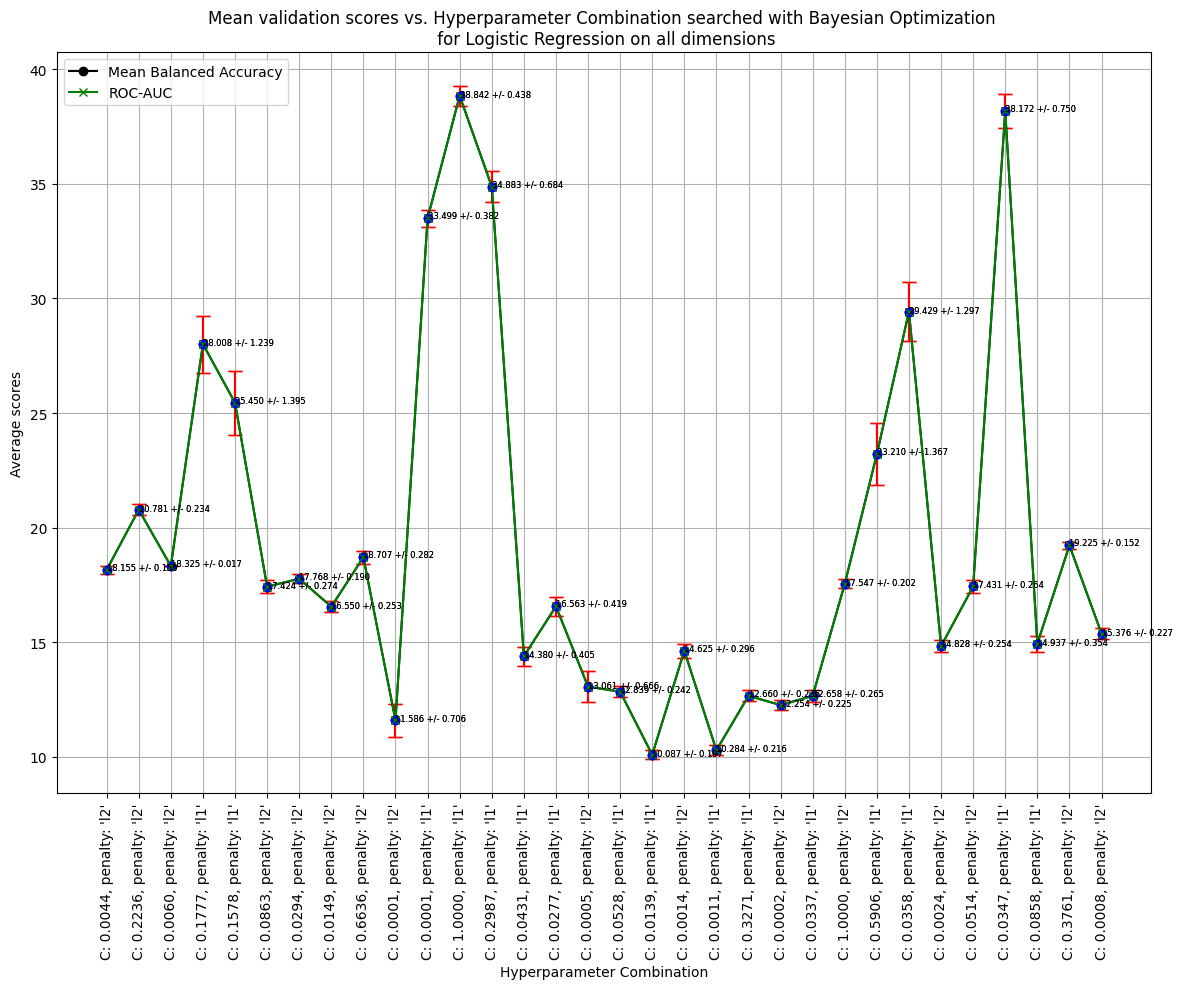

In [ ]:
plot_val_scores_vs_hparam(mean_test_scores=logreg_all_dim.cv_results_['mean_fit_time'], std_test_scores=logreg_all_dim.cv_results_['std_fit_time'], 
                          hparam_paradigm = "Bayesian Optimization",
                          params=logreg_all_dim.cv_results_['params'], model_name='Logistic Regression on all dimensions', mean_test_scores2=logreg_all_dim.cv_results_['mean_fit_time'], std_test_scores2=logreg_all_dim.cv_results_['std_fit_time'])

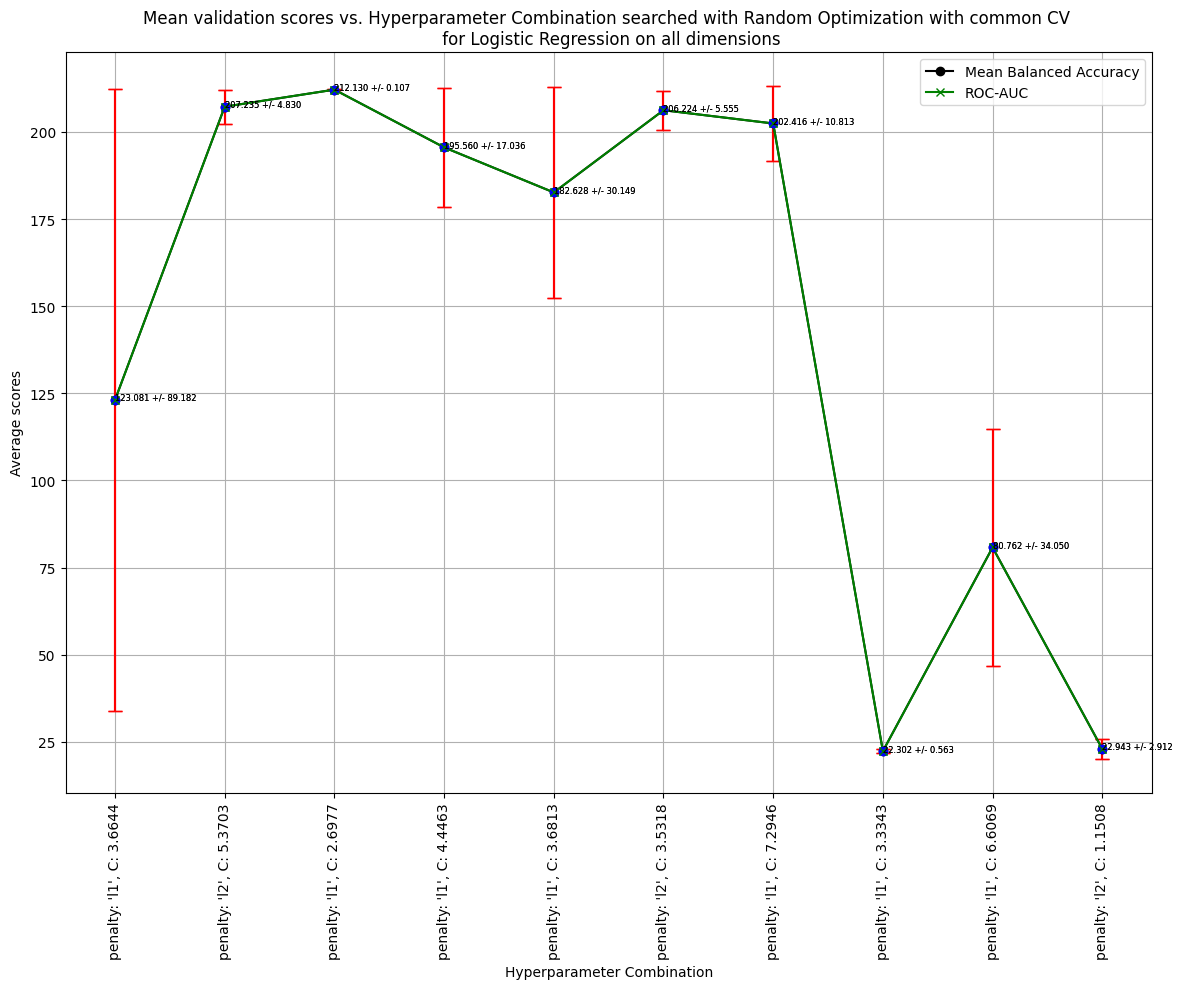

In [ ]:
plot_val_scores_vs_hparam(mean_test_scores=logreg_all_dim_common.cv_results_['mean_fit_time'], std_test_scores=logreg_all_dim_common.cv_results_['std_fit_time'], 
                          hparam_paradigm = "Random Optimization with common CV",
                          params=logreg_all_dim_common.cv_results_['params'], model_name='Logistic Regression on all dimensions', mean_test_scores2=logreg_all_dim_common.cv_results_['mean_fit_time'], std_test_scores2=logreg_all_dim_common.cv_results_['std_fit_time'])